In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 828)
(4629816, 8)
validation
(621056, 828)
(621056, 8)
test
(624904, 828)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 9:45 - loss: 2.2534 - STD: 0.0689 - MAE: 0.2197

  5/463 [..............................] - ETA: 7s - loss: 2.1148 - STD: 0.0517 - MAE: 0.2169  

  9/463 [..............................] - ETA: 7s - loss: 2.0989 - STD: 0.0509 - MAE: 0.2165

 13/463 [..............................] - ETA: 6s - loss: 2.0842 - STD: 0.0440 - MAE: 0.2166

 17/463 [>.............................] - ETA: 6s - loss: 2.0777 - STD: 0.0416 - MAE: 0.2167

 21/463 [>.............................] - ETA: 6s - loss: 2.0714 - STD: 0.0395 - MAE: 0.2166

 25/463 [>.............................] - ETA: 6s - loss: 2.0662 - STD: 0.0385 - MAE: 0.2166

 29/463 [>.............................] - ETA: 6s - loss: 2.0603 - STD: 0.0381 - MAE: 0.2164

 33/463 [=>............................] - ETA: 6s - loss: 2.0519 - STD: 0.0377 - MAE: 0.2162

 37/463 [=>............................] - ETA: 6s - loss: 2.0407 - STD: 0.0383 - MAE: 0.2158

 41/463 [=>............................] - ETA: 6s - loss: 2.0277 - STD: 0.0401 - MAE: 0.2153

 45/463 [=>............................] - ETA: 6s - loss: 2.0135 - STD: 0.0424 - MAE: 0.2146

 49/463 [==>...........................] - ETA: 6s - loss: 1.9988 - STD: 0.0453 - MAE: 0.2138

 53/463 [==>...........................] - ETA: 6s - loss: 1.9838 - STD: 0.0478 - MAE: 0.2131

 57/463 [==>...........................] - ETA: 6s - loss: 1.9682 - STD: 0.0502 - MAE: 0.2123

 61/463 [==>...........................] - ETA: 6s - loss: 1.9521 - STD: 0.0525 - MAE: 0.2115

 65/463 [===>..........................] - ETA: 6s - loss: 1.9355 - STD: 0.0550 - MAE: 0.2107

 69/463 [===>..........................] - ETA: 6s - loss: 1.9185 - STD: 0.0576 - MAE: 0.2097

 73/463 [===>..........................] - ETA: 5s - loss: 1.9010 - STD: 0.0603 - MAE: 0.2087

 77/463 [===>..........................] - ETA: 5s - loss: 1.8838 - STD: 0.0633 - MAE: 0.2076

 81/463 [====>.........................] - ETA: 5s - loss: 1.8672 - STD: 0.0662 - MAE: 0.2065

 85/463 [====>.........................] - ETA: 5s - loss: 1.8514 - STD: 0.0689 - MAE: 0.2054

 89/463 [====>.........................] - ETA: 5s - loss: 1.8361 - STD: 0.0716 - MAE: 0.2044

 93/463 [=====>........................] - ETA: 5s - loss: 1.8215 - STD: 0.0742 - MAE: 0.2034

 97/463 [=====>........................] - ETA: 5s - loss: 1.8073 - STD: 0.0767 - MAE: 0.2024

101/463 [=====>........................] - ETA: 5s - loss: 1.7941 - STD: 0.0790 - MAE: 0.2015

105/463 [=====>........................] - ETA: 5s - loss: 1.7812 - STD: 0.0813 - MAE: 0.2006

109/463 [======>.......................] - ETA: 5s - loss: 1.7688 - STD: 0.0834 - MAE: 0.1997

113/463 [======>.......................] - ETA: 5s - loss: 1.7568 - STD: 0.0854 - MAE: 0.1988

117/463 [======>.......................] - ETA: 5s - loss: 1.7454 - STD: 0.0874 - MAE: 0.1980

121/463 [======>.......................] - ETA: 5s - loss: 1.7340 - STD: 0.0893 - MAE: 0.1972

125/463 [=======>......................] - ETA: 5s - loss: 1.7236 - STD: 0.0911 - MAE: 0.1964

129/463 [=======>......................] - ETA: 5s - loss: 1.7134 - STD: 0.0929 - MAE: 0.1956

133/463 [=======>......................] - ETA: 5s - loss: 1.7035 - STD: 0.0946 - MAE: 0.1949

137/463 [=======>......................] - ETA: 4s - loss: 1.6939 - STD: 0.0963 - MAE: 0.1942

141/463 [========>.....................] - ETA: 4s - loss: 1.6846 - STD: 0.0979 - MAE: 0.1935

145/463 [========>.....................] - ETA: 4s - loss: 1.6756 - STD: 0.0994 - MAE: 0.1928

149/463 [========>.....................] - ETA: 4s - loss: 1.6670 - STD: 0.1009 - MAE: 0.1921

153/463 [========>.....................] - ETA: 4s - loss: 1.6589 - STD: 0.1024 - MAE: 0.1915

157/463 [=========>....................] - ETA: 4s - loss: 1.6508 - STD: 0.1037 - MAE: 0.1908

161/463 [=========>....................] - ETA: 4s - loss: 1.6431 - STD: 0.1051 - MAE: 0.1902

165/463 [=========>....................] - ETA: 4s - loss: 1.6356 - STD: 0.1064 - MAE: 0.1896

169/463 [=========>....................] - ETA: 4s - loss: 1.6285 - STD: 0.1077 - MAE: 0.1890

173/463 [==========>...................] - ETA: 4s - loss: 1.6217 - STD: 0.1089 - MAE: 0.1885

177/463 [==========>...................] - ETA: 4s - loss: 1.6149 - STD: 0.1101 - MAE: 0.1879

181/463 [==========>...................] - ETA: 4s - loss: 1.6084 - STD: 0.1112 - MAE: 0.1874

185/463 [==========>...................] - ETA: 4s - loss: 1.6018 - STD: 0.1123 - MAE: 0.1869

189/463 [===========>..................] - ETA: 4s - loss: 1.5956 - STD: 0.1134 - MAE: 0.1864

193/463 [===========>..................] - ETA: 4s - loss: 1.5897 - STD: 0.1145 - MAE: 0.1859

197/463 [===========>..................] - ETA: 4s - loss: 1.5840 - STD: 0.1155 - MAE: 0.1854

201/463 [============>.................] - ETA: 4s - loss: 1.5785 - STD: 0.1165 - MAE: 0.1850

205/463 [============>.................] - ETA: 3s - loss: 1.5732 - STD: 0.1174 - MAE: 0.1845

206/463 [============>.................] - ETA: 4s - loss: 1.5718 - STD: 0.1176 - MAE: 0.1844

210/463 [============>.................] - ETA: 4s - loss: 1.5664 - STD: 0.1186 - MAE: 0.1840

214/463 [============>.................] - ETA: 4s - loss: 1.5610 - STD: 0.1195 - MAE: 0.1835

218/463 [=============>................] - ETA: 4s - loss: 1.5559 - STD: 0.1203 - MAE: 0.1831

222/463 [=============>................] - ETA: 4s - loss: 1.5510 - STD: 0.1212 - MAE: 0.1827

226/463 [=============>................] - ETA: 4s - loss: 1.5462 - STD: 0.1221 - MAE: 0.1823

230/463 [=============>................] - ETA: 4s - loss: 1.5414 - STD: 0.1229 - MAE: 0.1819

234/463 [==============>...............] - ETA: 4s - loss: 1.5369 - STD: 0.1237 - MAE: 0.1815

238/463 [==============>...............] - ETA: 4s - loss: 1.5324 - STD: 0.1244 - MAE: 0.1812

242/463 [==============>...............] - ETA: 3s - loss: 1.5281 - STD: 0.1252 - MAE: 0.1808

246/463 [==============>...............] - ETA: 3s - loss: 1.5239 - STD: 0.1259 - MAE: 0.1804

250/463 [===============>..............] - ETA: 3s - loss: 1.5199 - STD: 0.1267 - MAE: 0.1801

254/463 [===============>..............] - ETA: 3s - loss: 1.5158 - STD: 0.1274 - MAE: 0.1798

258/463 [===============>..............] - ETA: 3s - loss: 1.5119 - STD: 0.1280 - MAE: 0.1794

262/463 [===============>..............] - ETA: 3s - loss: 1.5081 - STD: 0.1287 - MAE: 0.1791

266/463 [================>.............] - ETA: 3s - loss: 1.5042 - STD: 0.1294 - MAE: 0.1788

270/463 [================>.............] - ETA: 3s - loss: 1.5004 - STD: 0.1300 - MAE: 0.1785

274/463 [================>.............] - ETA: 3s - loss: 1.4968 - STD: 0.1306 - MAE: 0.1781

278/463 [=================>............] - ETA: 3s - loss: 1.4931 - STD: 0.1313 - MAE: 0.1778

282/463 [=================>............] - ETA: 3s - loss: 1.4898 - STD: 0.1319 - MAE: 0.1776

286/463 [=================>............] - ETA: 3s - loss: 1.4862 - STD: 0.1325 - MAE: 0.1773

290/463 [=================>............] - ETA: 3s - loss: 1.4829 - STD: 0.1330 - MAE: 0.1770

294/463 [==================>...........] - ETA: 2s - loss: 1.4797 - STD: 0.1336 - MAE: 0.1767

298/463 [==================>...........] - ETA: 2s - loss: 1.4765 - STD: 0.1342 - MAE: 0.1764

302/463 [==================>...........] - ETA: 2s - loss: 1.4732 - STD: 0.1347 - MAE: 0.1761

306/463 [==================>...........] - ETA: 2s - loss: 1.4700 - STD: 0.1352 - MAE: 0.1759

310/463 [===================>..........] - ETA: 2s - loss: 1.4668 - STD: 0.1358 - MAE: 0.1756

314/463 [===================>..........] - ETA: 2s - loss: 1.4636 - STD: 0.1363 - MAE: 0.1753

318/463 [===================>..........] - ETA: 2s - loss: 1.4605 - STD: 0.1368 - MAE: 0.1751

322/463 [===================>..........] - ETA: 2s - loss: 1.4575 - STD: 0.1373 - MAE: 0.1748

326/463 [====================>.........] - ETA: 2s - loss: 1.4547 - STD: 0.1378 - MAE: 0.1746

330/463 [====================>.........] - ETA: 2s - loss: 1.4521 - STD: 0.1383 - MAE: 0.1743

334/463 [====================>.........] - ETA: 2s - loss: 1.4496 - STD: 0.1388 - MAE: 0.1741

338/463 [====================>.........] - ETA: 2s - loss: 1.4471 - STD: 0.1392 - MAE: 0.1739

342/463 [=====================>........] - ETA: 2s - loss: 1.4444 - STD: 0.1397 - MAE: 0.1736

346/463 [=====================>........] - ETA: 2s - loss: 1.4417 - STD: 0.1401 - MAE: 0.1734

350/463 [=====================>........] - ETA: 1s - loss: 1.4390 - STD: 0.1405 - MAE: 0.1732

354/463 [=====================>........] - ETA: 1s - loss: 1.4364 - STD: 0.1410 - MAE: 0.1729

358/463 [======================>.......] - ETA: 1s - loss: 1.4338 - STD: 0.1414 - MAE: 0.1727

362/463 [======================>.......] - ETA: 1s - loss: 1.4312 - STD: 0.1418 - MAE: 0.1725

366/463 [======================>.......] - ETA: 1s - loss: 1.4286 - STD: 0.1422 - MAE: 0.1723

370/463 [======================>.......] - ETA: 1s - loss: 1.4263 - STD: 0.1426 - MAE: 0.1721

374/463 [=======================>......] - ETA: 1s - loss: 1.4239 - STD: 0.1430 - MAE: 0.1719

378/463 [=======================>......] - ETA: 1s - loss: 1.4215 - STD: 0.1434 - MAE: 0.1717

382/463 [=======================>......] - ETA: 1s - loss: 1.4192 - STD: 0.1438 - MAE: 0.1715

386/463 [========================>.....] - ETA: 1s - loss: 1.4168 - STD: 0.1442 - MAE: 0.1712

390/463 [========================>.....] - ETA: 1s - loss: 1.4144 - STD: 0.1446 - MAE: 0.1710

394/463 [========================>.....] - ETA: 1s - loss: 1.4121 - STD: 0.1450 - MAE: 0.1708

398/463 [========================>.....] - ETA: 1s - loss: 1.4100 - STD: 0.1453 - MAE: 0.1706

402/463 [=========================>....] - ETA: 1s - loss: 1.4078 - STD: 0.1457 - MAE: 0.1705

406/463 [=========================>....] - ETA: 0s - loss: 1.4055 - STD: 0.1460 - MAE: 0.1703

410/463 [=========================>....] - ETA: 0s - loss: 1.4035 - STD: 0.1464 - MAE: 0.1701

414/463 [=========================>....] - ETA: 0s - loss: 1.4014 - STD: 0.1467 - MAE: 0.1699

418/463 [==========================>...] - ETA: 0s - loss: 1.3992 - STD: 0.1471 - MAE: 0.1697

422/463 [==========================>...] - ETA: 0s - loss: 1.3971 - STD: 0.1474 - MAE: 0.1695

426/463 [==========================>...] - ETA: 0s - loss: 1.3949 - STD: 0.1478 - MAE: 0.1693

430/463 [==========================>...] - ETA: 0s - loss: 1.3928 - STD: 0.1481 - MAE: 0.1691

434/463 [===========================>..] - ETA: 0s - loss: 1.3908 - STD: 0.1484 - MAE: 0.1690

438/463 [===========================>..] - ETA: 0s - loss: 1.3888 - STD: 0.1487 - MAE: 0.1688

442/463 [===========================>..] - ETA: 0s - loss: 1.3868 - STD: 0.1491 - MAE: 0.1686

446/463 [===========================>..] - ETA: 0s - loss: 1.3848 - STD: 0.1494 - MAE: 0.1684

450/463 [============================>.] - ETA: 0s - loss: 1.3831 - STD: 0.1497 - MAE: 0.1683

454/463 [============================>.] - ETA: 0s - loss: 1.3812 - STD: 0.1500 - MAE: 0.1681

458/463 [============================>.] - ETA: 0s - loss: 1.3794 - STD: 0.1503 - MAE: 0.1679

462/463 [============================>.] - ETA: 0s - loss: 1.3775 - STD: 0.1506 - MAE: 0.1678

463/463 [==============================] - 10s 20ms/step - loss: 1.3770 - STD: 0.1507 - MAE: 0.1677 - val_loss: 1.2467 - val_STD: 0.1780 - val_MAE: 0.1550


Epoch 2/10000


  1/463 [..............................] - ETA: 20s - loss: 1.1648 - STD: 0.1844 - MAE: 0.1491

  4/463 [..............................] - ETA: 7s - loss: 1.1678 - STD: 0.1847 - MAE: 0.1492 

  8/463 [..............................] - ETA: 7s - loss: 1.1589 - STD: 0.1846 - MAE: 0.1487

 12/463 [..............................] - ETA: 7s - loss: 1.1621 - STD: 0.1848 - MAE: 0.1488

 16/463 [>.............................] - ETA: 7s - loss: 1.1597 - STD: 0.1850 - MAE: 0.1486

 20/463 [>.............................] - ETA: 6s - loss: 1.1569 - STD: 0.1851 - MAE: 0.1485

 24/463 [>.............................] - ETA: 6s - loss: 1.1554 - STD: 0.1853 - MAE: 0.1483

 28/463 [>.............................] - ETA: 6s - loss: 1.1539 - STD: 0.1855 - MAE: 0.1481

 32/463 [=>............................] - ETA: 6s - loss: 1.1560 - STD: 0.1858 - MAE: 0.1482

 36/463 [=>............................] - ETA: 6s - loss: 1.1556 - STD: 0.1860 - MAE: 0.1481

 40/463 [=>............................] - ETA: 6s - loss: 1.1547 - STD: 0.1861 - MAE: 0.1480

 44/463 [=>............................] - ETA: 6s - loss: 1.1548 - STD: 0.1862 - MAE: 0.1479

 48/463 [==>...........................] - ETA: 6s - loss: 1.1549 - STD: 0.1864 - MAE: 0.1479

 52/463 [==>...........................] - ETA: 6s - loss: 1.1543 - STD: 0.1864 - MAE: 0.1478

 56/463 [==>...........................] - ETA: 6s - loss: 1.1536 - STD: 0.1865 - MAE: 0.1477

 60/463 [==>...........................] - ETA: 6s - loss: 1.1527 - STD: 0.1866 - MAE: 0.1477

 64/463 [===>..........................] - ETA: 6s - loss: 1.1521 - STD: 0.1867 - MAE: 0.1476

 68/463 [===>..........................] - ETA: 6s - loss: 1.1517 - STD: 0.1868 - MAE: 0.1475

 72/463 [===>..........................] - ETA: 5s - loss: 1.1511 - STD: 0.1869 - MAE: 0.1475

 76/463 [===>..........................] - ETA: 5s - loss: 1.1513 - STD: 0.1869 - MAE: 0.1474

 80/463 [====>.........................] - ETA: 5s - loss: 1.1501 - STD: 0.1871 - MAE: 0.1473

 84/463 [====>.........................] - ETA: 5s - loss: 1.1495 - STD: 0.1871 - MAE: 0.1473

 88/463 [====>.........................] - ETA: 5s - loss: 1.1486 - STD: 0.1873 - MAE: 0.1472

 92/463 [====>.........................] - ETA: 5s - loss: 1.1476 - STD: 0.1874 - MAE: 0.1471

 96/463 [=====>........................] - ETA: 5s - loss: 1.1467 - STD: 0.1875 - MAE: 0.1470

100/463 [=====>........................] - ETA: 5s - loss: 1.1459 - STD: 0.1876 - MAE: 0.1469

104/463 [=====>........................] - ETA: 5s - loss: 1.1462 - STD: 0.1876 - MAE: 0.1469

108/463 [=====>........................] - ETA: 5s - loss: 1.1456 - STD: 0.1877 - MAE: 0.1468

112/463 [======>.......................] - ETA: 5s - loss: 1.1453 - STD: 0.1878 - MAE: 0.1468

116/463 [======>.......................] - ETA: 5s - loss: 1.1447 - STD: 0.1879 - MAE: 0.1467

120/463 [======>.......................] - ETA: 5s - loss: 1.1444 - STD: 0.1880 - MAE: 0.1467

124/463 [=======>......................] - ETA: 5s - loss: 1.1435 - STD: 0.1880 - MAE: 0.1466

128/463 [=======>......................] - ETA: 5s - loss: 1.1429 - STD: 0.1881 - MAE: 0.1466

132/463 [=======>......................] - ETA: 5s - loss: 1.1421 - STD: 0.1882 - MAE: 0.1465

136/463 [=======>......................] - ETA: 4s - loss: 1.1413 - STD: 0.1883 - MAE: 0.1464

140/463 [========>.....................] - ETA: 4s - loss: 1.1406 - STD: 0.1884 - MAE: 0.1463

144/463 [========>.....................] - ETA: 4s - loss: 1.1398 - STD: 0.1885 - MAE: 0.1462

148/463 [========>.....................] - ETA: 4s - loss: 1.1390 - STD: 0.1886 - MAE: 0.1462

151/463 [========>.....................] - ETA: 4s - loss: 1.1387 - STD: 0.1887 - MAE: 0.1461

155/463 [=========>....................] - ETA: 4s - loss: 1.1381 - STD: 0.1887 - MAE: 0.1461

159/463 [=========>....................] - ETA: 4s - loss: 1.1378 - STD: 0.1888 - MAE: 0.1460

163/463 [=========>....................] - ETA: 4s - loss: 1.1381 - STD: 0.1889 - MAE: 0.1460

167/463 [=========>....................] - ETA: 4s - loss: 1.1378 - STD: 0.1890 - MAE: 0.1459

171/463 [==========>...................] - ETA: 4s - loss: 1.1375 - STD: 0.1891 - MAE: 0.1459

175/463 [==========>...................] - ETA: 4s - loss: 1.1371 - STD: 0.1892 - MAE: 0.1459

179/463 [==========>...................] - ETA: 4s - loss: 1.1369 - STD: 0.1892 - MAE: 0.1458

183/463 [==========>...................] - ETA: 4s - loss: 1.1368 - STD: 0.1893 - MAE: 0.1458

187/463 [===========>..................] - ETA: 4s - loss: 1.1363 - STD: 0.1894 - MAE: 0.1457

191/463 [===========>..................] - ETA: 4s - loss: 1.1358 - STD: 0.1894 - MAE: 0.1457

195/463 [===========>..................] - ETA: 4s - loss: 1.1352 - STD: 0.1895 - MAE: 0.1456

199/463 [===========>..................] - ETA: 4s - loss: 1.1345 - STD: 0.1896 - MAE: 0.1455

203/463 [============>.................] - ETA: 3s - loss: 1.1339 - STD: 0.1897 - MAE: 0.1455

207/463 [============>.................] - ETA: 3s - loss: 1.1335 - STD: 0.1897 - MAE: 0.1454

211/463 [============>.................] - ETA: 3s - loss: 1.1330 - STD: 0.1898 - MAE: 0.1454

215/463 [============>.................] - ETA: 3s - loss: 1.1324 - STD: 0.1898 - MAE: 0.1453

219/463 [=============>................] - ETA: 3s - loss: 1.1316 - STD: 0.1899 - MAE: 0.1453

223/463 [=============>................] - ETA: 3s - loss: 1.1309 - STD: 0.1900 - MAE: 0.1452

227/463 [=============>................] - ETA: 3s - loss: 1.1302 - STD: 0.1901 - MAE: 0.1451

231/463 [=============>................] - ETA: 3s - loss: 1.1295 - STD: 0.1901 - MAE: 0.1451

235/463 [==============>...............] - ETA: 3s - loss: 1.1288 - STD: 0.1902 - MAE: 0.1450

239/463 [==============>...............] - ETA: 3s - loss: 1.1282 - STD: 0.1903 - MAE: 0.1449

243/463 [==============>...............] - ETA: 3s - loss: 1.1275 - STD: 0.1904 - MAE: 0.1449

247/463 [===============>..............] - ETA: 3s - loss: 1.1268 - STD: 0.1905 - MAE: 0.1448

251/463 [===============>..............] - ETA: 3s - loss: 1.1261 - STD: 0.1906 - MAE: 0.1447

255/463 [===============>..............] - ETA: 3s - loss: 1.1252 - STD: 0.1907 - MAE: 0.1446

259/463 [===============>..............] - ETA: 3s - loss: 1.1247 - STD: 0.1908 - MAE: 0.1446

263/463 [================>.............] - ETA: 3s - loss: 1.1241 - STD: 0.1909 - MAE: 0.1445

267/463 [================>.............] - ETA: 3s - loss: 1.1239 - STD: 0.1909 - MAE: 0.1445

271/463 [================>.............] - ETA: 2s - loss: 1.1236 - STD: 0.1910 - MAE: 0.1444

275/463 [================>.............] - ETA: 2s - loss: 1.1235 - STD: 0.1911 - MAE: 0.1444

279/463 [=================>............] - ETA: 2s - loss: 1.1233 - STD: 0.1912 - MAE: 0.1443

283/463 [=================>............] - ETA: 2s - loss: 1.1228 - STD: 0.1912 - MAE: 0.1443

287/463 [=================>............] - ETA: 2s - loss: 1.1223 - STD: 0.1913 - MAE: 0.1442

291/463 [=================>............] - ETA: 2s - loss: 1.1218 - STD: 0.1914 - MAE: 0.1442

295/463 [==================>...........] - ETA: 2s - loss: 1.1212 - STD: 0.1914 - MAE: 0.1441

299/463 [==================>...........] - ETA: 2s - loss: 1.1206 - STD: 0.1915 - MAE: 0.1441

303/463 [==================>...........] - ETA: 2s - loss: 1.1199 - STD: 0.1916 - MAE: 0.1440

307/463 [==================>...........] - ETA: 2s - loss: 1.1193 - STD: 0.1916 - MAE: 0.1439

311/463 [===================>..........] - ETA: 2s - loss: 1.1187 - STD: 0.1917 - MAE: 0.1439

315/463 [===================>..........] - ETA: 2s - loss: 1.1179 - STD: 0.1918 - MAE: 0.1438

319/463 [===================>..........] - ETA: 2s - loss: 1.1172 - STD: 0.1919 - MAE: 0.1437

323/463 [===================>..........] - ETA: 2s - loss: 1.1165 - STD: 0.1919 - MAE: 0.1437

327/463 [====================>.........] - ETA: 2s - loss: 1.1158 - STD: 0.1920 - MAE: 0.1436

331/463 [====================>.........] - ETA: 2s - loss: 1.1153 - STD: 0.1921 - MAE: 0.1435

335/463 [====================>.........] - ETA: 1s - loss: 1.1148 - STD: 0.1922 - MAE: 0.1435

339/463 [====================>.........] - ETA: 1s - loss: 1.1144 - STD: 0.1923 - MAE: 0.1434

343/463 [=====================>........] - ETA: 1s - loss: 1.1138 - STD: 0.1923 - MAE: 0.1434

347/463 [=====================>........] - ETA: 1s - loss: 1.1133 - STD: 0.1924 - MAE: 0.1433

351/463 [=====================>........] - ETA: 1s - loss: 1.1129 - STD: 0.1925 - MAE: 0.1433

355/463 [======================>.......] - ETA: 1s - loss: 1.1123 - STD: 0.1926 - MAE: 0.1432

359/463 [======================>.......] - ETA: 1s - loss: 1.1119 - STD: 0.1926 - MAE: 0.1432

363/463 [======================>.......] - ETA: 1s - loss: 1.1115 - STD: 0.1927 - MAE: 0.1431

367/463 [======================>.......] - ETA: 1s - loss: 1.1114 - STD: 0.1928 - MAE: 0.1431

371/463 [=======================>......] - ETA: 1s - loss: 1.1110 - STD: 0.1928 - MAE: 0.1430

375/463 [=======================>......] - ETA: 1s - loss: 1.1104 - STD: 0.1929 - MAE: 0.1430

379/463 [=======================>......] - ETA: 1s - loss: 1.1098 - STD: 0.1930 - MAE: 0.1429

383/463 [=======================>......] - ETA: 1s - loss: 1.1095 - STD: 0.1930 - MAE: 0.1429

387/463 [========================>.....] - ETA: 1s - loss: 1.1091 - STD: 0.1931 - MAE: 0.1428

391/463 [========================>.....] - ETA: 1s - loss: 1.1087 - STD: 0.1932 - MAE: 0.1428

395/463 [========================>.....] - ETA: 1s - loss: 1.1084 - STD: 0.1932 - MAE: 0.1427

399/463 [========================>.....] - ETA: 0s - loss: 1.1081 - STD: 0.1933 - MAE: 0.1427

403/463 [=========================>....] - ETA: 0s - loss: 1.1077 - STD: 0.1933 - MAE: 0.1427

407/463 [=========================>....] - ETA: 0s - loss: 1.1071 - STD: 0.1934 - MAE: 0.1426

411/463 [=========================>....] - ETA: 0s - loss: 1.1066 - STD: 0.1935 - MAE: 0.1426

415/463 [=========================>....] - ETA: 0s - loss: 1.1062 - STD: 0.1935 - MAE: 0.1425

419/463 [==========================>...] - ETA: 0s - loss: 1.1058 - STD: 0.1936 - MAE: 0.1425

423/463 [==========================>...] - ETA: 0s - loss: 1.1053 - STD: 0.1936 - MAE: 0.1424

427/463 [==========================>...] - ETA: 0s - loss: 1.1048 - STD: 0.1937 - MAE: 0.1424

431/463 [==========================>...] - ETA: 0s - loss: 1.1044 - STD: 0.1938 - MAE: 0.1423

435/463 [===========================>..] - ETA: 0s - loss: 1.1038 - STD: 0.1938 - MAE: 0.1423

439/463 [===========================>..] - ETA: 0s - loss: 1.1034 - STD: 0.1939 - MAE: 0.1422

443/463 [===========================>..] - ETA: 0s - loss: 1.1028 - STD: 0.1940 - MAE: 0.1422

447/463 [===========================>..] - ETA: 0s - loss: 1.1023 - STD: 0.1940 - MAE: 0.1421

451/463 [============================>.] - ETA: 0s - loss: 1.1018 - STD: 0.1941 - MAE: 0.1420

455/463 [============================>.] - ETA: 0s - loss: 1.1013 - STD: 0.1942 - MAE: 0.1420

459/463 [============================>.] - ETA: 0s - loss: 1.1008 - STD: 0.1943 - MAE: 0.1419

463/463 [==============================] - ETA: 0s - loss: 1.1003 - STD: 0.1943 - MAE: 0.1419

463/463 [==============================] - 8s 17ms/step - loss: 1.1003 - STD: 0.1943 - MAE: 0.1419 - val_loss: 1.1344 - val_STD: 0.1972 - val_MAE: 0.1426


Epoch 3/10000


  1/463 [..............................] - ETA: 20s - loss: 1.0571 - STD: 0.2025 - MAE: 0.1365

  5/463 [..............................] - ETA: 7s - loss: 1.0506 - STD: 0.2022 - MAE: 0.1362 

  9/463 [..............................] - ETA: 7s - loss: 1.0485 - STD: 0.2022 - MAE: 0.1361

 13/463 [..............................] - ETA: 7s - loss: 1.0453 - STD: 0.2020 - MAE: 0.1360

 17/463 [>.............................] - ETA: 6s - loss: 1.0426 - STD: 0.2020 - MAE: 0.1358

 21/463 [>.............................] - ETA: 6s - loss: 1.0420 - STD: 0.2023 - MAE: 0.1357

 25/463 [>.............................] - ETA: 6s - loss: 1.0412 - STD: 0.2022 - MAE: 0.1357

 29/463 [>.............................] - ETA: 6s - loss: 1.0417 - STD: 0.2023 - MAE: 0.1356

 33/463 [=>............................] - ETA: 6s - loss: 1.0419 - STD: 0.2022 - MAE: 0.1357

 37/463 [=>............................] - ETA: 6s - loss: 1.0423 - STD: 0.2023 - MAE: 0.1356

 41/463 [=>............................] - ETA: 6s - loss: 1.0406 - STD: 0.2024 - MAE: 0.1355

 45/463 [=>............................] - ETA: 6s - loss: 1.0397 - STD: 0.2023 - MAE: 0.1355

 49/463 [==>...........................] - ETA: 6s - loss: 1.0388 - STD: 0.2024 - MAE: 0.1354

 53/463 [==>...........................] - ETA: 6s - loss: 1.0378 - STD: 0.2025 - MAE: 0.1353

 57/463 [==>...........................] - ETA: 6s - loss: 1.0374 - STD: 0.2025 - MAE: 0.1353

 61/463 [==>...........................] - ETA: 6s - loss: 1.0372 - STD: 0.2026 - MAE: 0.1352

 65/463 [===>..........................] - ETA: 6s - loss: 1.0377 - STD: 0.2026 - MAE: 0.1352

 69/463 [===>..........................] - ETA: 6s - loss: 1.0371 - STD: 0.2027 - MAE: 0.1352

 73/463 [===>..........................] - ETA: 5s - loss: 1.0372 - STD: 0.2028 - MAE: 0.1352

 77/463 [===>..........................] - ETA: 5s - loss: 1.0375 - STD: 0.2029 - MAE: 0.1351

 81/463 [====>.........................] - ETA: 5s - loss: 1.0381 - STD: 0.2029 - MAE: 0.1351

 85/463 [====>.........................] - ETA: 5s - loss: 1.0379 - STD: 0.2030 - MAE: 0.1351

 89/463 [====>.........................] - ETA: 5s - loss: 1.0381 - STD: 0.2030 - MAE: 0.1351

 93/463 [=====>........................] - ETA: 5s - loss: 1.0386 - STD: 0.2030 - MAE: 0.1351

 97/463 [=====>........................] - ETA: 5s - loss: 1.0390 - STD: 0.2031 - MAE: 0.1351

101/463 [=====>........................] - ETA: 5s - loss: 1.0390 - STD: 0.2031 - MAE: 0.1351

105/463 [=====>........................] - ETA: 5s - loss: 1.0386 - STD: 0.2031 - MAE: 0.1351

109/463 [======>.......................] - ETA: 5s - loss: 1.0380 - STD: 0.2031 - MAE: 0.1351

113/463 [======>.......................] - ETA: 5s - loss: 1.0376 - STD: 0.2031 - MAE: 0.1350

117/463 [======>.......................] - ETA: 5s - loss: 1.0374 - STD: 0.2031 - MAE: 0.1350

121/463 [======>.......................] - ETA: 5s - loss: 1.0368 - STD: 0.2031 - MAE: 0.1349

125/463 [=======>......................] - ETA: 5s - loss: 1.0361 - STD: 0.2032 - MAE: 0.1349

129/463 [=======>......................] - ETA: 5s - loss: 1.0352 - STD: 0.2033 - MAE: 0.1348

133/463 [=======>......................] - ETA: 5s - loss: 1.0346 - STD: 0.2033 - MAE: 0.1348

137/463 [=======>......................] - ETA: 5s - loss: 1.0340 - STD: 0.2034 - MAE: 0.1347

141/463 [========>.....................] - ETA: 4s - loss: 1.0341 - STD: 0.2034 - MAE: 0.1347

145/463 [========>.....................] - ETA: 4s - loss: 1.0338 - STD: 0.2035 - MAE: 0.1346

149/463 [========>.....................] - ETA: 4s - loss: 1.0333 - STD: 0.2036 - MAE: 0.1346

153/463 [========>.....................] - ETA: 4s - loss: 1.0327 - STD: 0.2036 - MAE: 0.1345

157/463 [=========>....................] - ETA: 4s - loss: 1.0324 - STD: 0.2036 - MAE: 0.1345

161/463 [=========>....................] - ETA: 4s - loss: 1.0322 - STD: 0.2037 - MAE: 0.1345

165/463 [=========>....................] - ETA: 4s - loss: 1.0318 - STD: 0.2038 - MAE: 0.1344

169/463 [=========>....................] - ETA: 4s - loss: 1.0314 - STD: 0.2038 - MAE: 0.1344

173/463 [==========>...................] - ETA: 4s - loss: 1.0308 - STD: 0.2038 - MAE: 0.1343

177/463 [==========>...................] - ETA: 4s - loss: 1.0306 - STD: 0.2039 - MAE: 0.1343

181/463 [==========>...................] - ETA: 4s - loss: 1.0304 - STD: 0.2039 - MAE: 0.1342

185/463 [==========>...................] - ETA: 4s - loss: 1.0301 - STD: 0.2040 - MAE: 0.1342

189/463 [===========>..................] - ETA: 4s - loss: 1.0302 - STD: 0.2040 - MAE: 0.1342

193/463 [===========>..................] - ETA: 4s - loss: 1.0302 - STD: 0.2041 - MAE: 0.1342

197/463 [===========>..................] - ETA: 4s - loss: 1.0298 - STD: 0.2041 - MAE: 0.1341

201/463 [============>.................] - ETA: 4s - loss: 1.0296 - STD: 0.2042 - MAE: 0.1341

205/463 [============>.................] - ETA: 3s - loss: 1.0292 - STD: 0.2042 - MAE: 0.1341

209/463 [============>.................] - ETA: 3s - loss: 1.0289 - STD: 0.2042 - MAE: 0.1341

213/463 [============>.................] - ETA: 3s - loss: 1.0285 - STD: 0.2042 - MAE: 0.1340

217/463 [=============>................] - ETA: 3s - loss: 1.0283 - STD: 0.2043 - MAE: 0.1340

221/463 [=============>................] - ETA: 3s - loss: 1.0280 - STD: 0.2043 - MAE: 0.1340

225/463 [=============>................] - ETA: 3s - loss: 1.0275 - STD: 0.2044 - MAE: 0.1339

229/463 [=============>................] - ETA: 3s - loss: 1.0271 - STD: 0.2044 - MAE: 0.1339

233/463 [==============>...............] - ETA: 3s - loss: 1.0269 - STD: 0.2045 - MAE: 0.1338

237/463 [==============>...............] - ETA: 3s - loss: 1.0271 - STD: 0.2045 - MAE: 0.1338

241/463 [==============>...............] - ETA: 3s - loss: 1.0266 - STD: 0.2045 - MAE: 0.1338

245/463 [==============>...............] - ETA: 3s - loss: 1.0262 - STD: 0.2046 - MAE: 0.1338

249/463 [===============>..............] - ETA: 3s - loss: 1.0256 - STD: 0.2046 - MAE: 0.1337

253/463 [===============>..............] - ETA: 3s - loss: 1.0252 - STD: 0.2047 - MAE: 0.1337

257/463 [===============>..............] - ETA: 3s - loss: 1.0248 - STD: 0.2047 - MAE: 0.1336

261/463 [===============>..............] - ETA: 3s - loss: 1.0244 - STD: 0.2047 - MAE: 0.1336

265/463 [================>.............] - ETA: 3s - loss: 1.0241 - STD: 0.2048 - MAE: 0.1336

269/463 [================>.............] - ETA: 2s - loss: 1.0241 - STD: 0.2048 - MAE: 0.1336

273/463 [================>.............] - ETA: 2s - loss: 1.0237 - STD: 0.2048 - MAE: 0.1335

277/463 [================>.............] - ETA: 2s - loss: 1.0234 - STD: 0.2049 - MAE: 0.1335

281/463 [=================>............] - ETA: 2s - loss: 1.0229 - STD: 0.2049 - MAE: 0.1334

285/463 [=================>............] - ETA: 2s - loss: 1.0226 - STD: 0.2050 - MAE: 0.1334

289/463 [=================>............] - ETA: 2s - loss: 1.0223 - STD: 0.2050 - MAE: 0.1334

293/463 [=================>............] - ETA: 2s - loss: 1.0221 - STD: 0.2051 - MAE: 0.1333

297/463 [==================>...........] - ETA: 2s - loss: 1.0220 - STD: 0.2051 - MAE: 0.1333

301/463 [==================>...........] - ETA: 2s - loss: 1.0217 - STD: 0.2051 - MAE: 0.1333

305/463 [==================>...........] - ETA: 2s - loss: 1.0215 - STD: 0.2052 - MAE: 0.1332

309/463 [===================>..........] - ETA: 2s - loss: 1.0211 - STD: 0.2052 - MAE: 0.1332

313/463 [===================>..........] - ETA: 2s - loss: 1.0208 - STD: 0.2052 - MAE: 0.1332

317/463 [===================>..........] - ETA: 2s - loss: 1.0205 - STD: 0.2053 - MAE: 0.1331

321/463 [===================>..........] - ETA: 2s - loss: 1.0201 - STD: 0.2053 - MAE: 0.1331

325/463 [====================>.........] - ETA: 2s - loss: 1.0198 - STD: 0.2054 - MAE: 0.1331

329/463 [====================>.........] - ETA: 2s - loss: 1.0197 - STD: 0.2054 - MAE: 0.1330

333/463 [====================>.........] - ETA: 1s - loss: 1.0197 - STD: 0.2054 - MAE: 0.1330

337/463 [====================>.........] - ETA: 1s - loss: 1.0194 - STD: 0.2055 - MAE: 0.1330

341/463 [=====================>........] - ETA: 1s - loss: 1.0190 - STD: 0.2055 - MAE: 0.1330

345/463 [=====================>........] - ETA: 1s - loss: 1.0186 - STD: 0.2056 - MAE: 0.1329

349/463 [=====================>........] - ETA: 1s - loss: 1.0183 - STD: 0.2056 - MAE: 0.1329

353/463 [=====================>........] - ETA: 1s - loss: 1.0181 - STD: 0.2057 - MAE: 0.1328

357/463 [======================>.......] - ETA: 1s - loss: 1.0177 - STD: 0.2057 - MAE: 0.1328

361/463 [======================>.......] - ETA: 1s - loss: 1.0173 - STD: 0.2057 - MAE: 0.1328

365/463 [======================>.......] - ETA: 1s - loss: 1.0170 - STD: 0.2058 - MAE: 0.1327

369/463 [======================>.......] - ETA: 1s - loss: 1.0168 - STD: 0.2058 - MAE: 0.1327

373/463 [=======================>......] - ETA: 1s - loss: 1.0164 - STD: 0.2058 - MAE: 0.1327

377/463 [=======================>......] - ETA: 1s - loss: 1.0161 - STD: 0.2059 - MAE: 0.1326

381/463 [=======================>......] - ETA: 1s - loss: 1.0157 - STD: 0.2059 - MAE: 0.1326

385/463 [=======================>......] - ETA: 1s - loss: 1.0155 - STD: 0.2060 - MAE: 0.1326

389/463 [========================>.....] - ETA: 1s - loss: 1.0151 - STD: 0.2060 - MAE: 0.1325

393/463 [========================>.....] - ETA: 1s - loss: 1.0147 - STD: 0.2060 - MAE: 0.1325

397/463 [========================>.....] - ETA: 1s - loss: 1.0145 - STD: 0.2061 - MAE: 0.1325

401/463 [========================>.....] - ETA: 0s - loss: 1.0141 - STD: 0.2061 - MAE: 0.1324

405/463 [=========================>....] - ETA: 0s - loss: 1.0138 - STD: 0.2062 - MAE: 0.1324

409/463 [=========================>....] - ETA: 0s - loss: 1.0135 - STD: 0.2062 - MAE: 0.1324

413/463 [=========================>....] - ETA: 0s - loss: 1.0134 - STD: 0.2062 - MAE: 0.1323

417/463 [==========================>...] - ETA: 0s - loss: 1.0130 - STD: 0.2063 - MAE: 0.1323

421/463 [==========================>...] - ETA: 0s - loss: 1.0126 - STD: 0.2063 - MAE: 0.1323

425/463 [==========================>...] - ETA: 0s - loss: 1.0123 - STD: 0.2063 - MAE: 0.1322

429/463 [==========================>...] - ETA: 0s - loss: 1.0118 - STD: 0.2064 - MAE: 0.1322

433/463 [===========================>..] - ETA: 0s - loss: 1.0115 - STD: 0.2064 - MAE: 0.1322

437/463 [===========================>..] - ETA: 0s - loss: 1.0113 - STD: 0.2065 - MAE: 0.1321

441/463 [===========================>..] - ETA: 0s - loss: 1.0110 - STD: 0.2065 - MAE: 0.1321

445/463 [===========================>..] - ETA: 0s - loss: 1.0106 - STD: 0.2066 - MAE: 0.1321

449/463 [============================>.] - ETA: 0s - loss: 1.0103 - STD: 0.2066 - MAE: 0.1320

453/463 [============================>.] - ETA: 0s - loss: 1.0103 - STD: 0.2066 - MAE: 0.1320

457/463 [============================>.] - ETA: 0s - loss: 1.0102 - STD: 0.2067 - MAE: 0.1320

461/463 [============================>.] - ETA: 0s - loss: 1.0100 - STD: 0.2067 - MAE: 0.1320

463/463 [==============================] - 8s 17ms/step - loss: 1.0099 - STD: 0.2067 - MAE: 0.1319 - val_loss: 1.1011 - val_STD: 0.2040 - val_MAE: 0.1384


Epoch 4/10000


  1/463 [..............................] - ETA: 20s - loss: 1.0009 - STD: 0.2097 - MAE: 0.1304

  4/463 [..............................] - ETA: 7s - loss: 0.9931 - STD: 0.2096 - MAE: 0.1298 

  8/463 [..............................] - ETA: 7s - loss: 0.9906 - STD: 0.2102 - MAE: 0.1295

 12/463 [..............................] - ETA: 7s - loss: 0.9932 - STD: 0.2100 - MAE: 0.1297

 16/463 [>.............................] - ETA: 7s - loss: 0.9904 - STD: 0.2101 - MAE: 0.1294

 20/463 [>.............................] - ETA: 7s - loss: 0.9880 - STD: 0.2102 - MAE: 0.1292

 24/463 [>.............................] - ETA: 6s - loss: 0.9849 - STD: 0.2102 - MAE: 0.1291

 28/463 [>.............................] - ETA: 6s - loss: 0.9835 - STD: 0.2103 - MAE: 0.1290

 32/463 [=>............................] - ETA: 6s - loss: 0.9811 - STD: 0.2105 - MAE: 0.1287

 36/463 [=>............................] - ETA: 6s - loss: 0.9785 - STD: 0.2106 - MAE: 0.1285

 40/463 [=>............................] - ETA: 6s - loss: 0.9765 - STD: 0.2106 - MAE: 0.1284

 44/463 [=>............................] - ETA: 6s - loss: 0.9754 - STD: 0.2107 - MAE: 0.1283

 48/463 [==>...........................] - ETA: 6s - loss: 0.9741 - STD: 0.2108 - MAE: 0.1282

 52/463 [==>...........................] - ETA: 6s - loss: 0.9729 - STD: 0.2109 - MAE: 0.1281

 56/463 [==>...........................] - ETA: 6s - loss: 0.9729 - STD: 0.2110 - MAE: 0.1280

 60/463 [==>...........................] - ETA: 6s - loss: 0.9728 - STD: 0.2111 - MAE: 0.1280

 64/463 [===>..........................] - ETA: 6s - loss: 0.9746 - STD: 0.2112 - MAE: 0.1281

 68/463 [===>..........................] - ETA: 6s - loss: 0.9743 - STD: 0.2112 - MAE: 0.1280

 72/463 [===>..........................] - ETA: 6s - loss: 0.9732 - STD: 0.2113 - MAE: 0.1279

 76/463 [===>..........................] - ETA: 6s - loss: 0.9729 - STD: 0.2114 - MAE: 0.1279

 80/463 [====>.........................] - ETA: 5s - loss: 0.9730 - STD: 0.2114 - MAE: 0.1279

 84/463 [====>.........................] - ETA: 5s - loss: 0.9728 - STD: 0.2114 - MAE: 0.1279

 88/463 [====>.........................] - ETA: 5s - loss: 0.9731 - STD: 0.2115 - MAE: 0.1279

 92/463 [====>.........................] - ETA: 5s - loss: 0.9738 - STD: 0.2115 - MAE: 0.1279

 96/463 [=====>........................] - ETA: 5s - loss: 0.9745 - STD: 0.2115 - MAE: 0.1279

100/463 [=====>........................] - ETA: 5s - loss: 0.9747 - STD: 0.2115 - MAE: 0.1279

104/463 [=====>........................] - ETA: 5s - loss: 0.9744 - STD: 0.2115 - MAE: 0.1279

108/463 [=====>........................] - ETA: 5s - loss: 0.9740 - STD: 0.2115 - MAE: 0.1279

112/463 [======>.......................] - ETA: 5s - loss: 0.9732 - STD: 0.2116 - MAE: 0.1278

116/463 [======>.......................] - ETA: 5s - loss: 0.9723 - STD: 0.2116 - MAE: 0.1278

120/463 [======>.......................] - ETA: 5s - loss: 0.9716 - STD: 0.2116 - MAE: 0.1277

124/463 [=======>......................] - ETA: 5s - loss: 0.9714 - STD: 0.2116 - MAE: 0.1277

128/463 [=======>......................] - ETA: 5s - loss: 0.9708 - STD: 0.2117 - MAE: 0.1277

132/463 [=======>......................] - ETA: 5s - loss: 0.9705 - STD: 0.2117 - MAE: 0.1276

136/463 [=======>......................] - ETA: 5s - loss: 0.9701 - STD: 0.2117 - MAE: 0.1276

140/463 [========>.....................] - ETA: 5s - loss: 0.9696 - STD: 0.2118 - MAE: 0.1276

144/463 [========>.....................] - ETA: 4s - loss: 0.9693 - STD: 0.2118 - MAE: 0.1275

148/463 [========>.....................] - ETA: 4s - loss: 0.9693 - STD: 0.2119 - MAE: 0.1275

152/463 [========>.....................] - ETA: 4s - loss: 0.9692 - STD: 0.2119 - MAE: 0.1275

156/463 [=========>....................] - ETA: 4s - loss: 0.9689 - STD: 0.2119 - MAE: 0.1274

160/463 [=========>....................] - ETA: 4s - loss: 0.9689 - STD: 0.2120 - MAE: 0.1274

164/463 [=========>....................] - ETA: 4s - loss: 0.9689 - STD: 0.2120 - MAE: 0.1274

168/463 [=========>....................] - ETA: 4s - loss: 0.9686 - STD: 0.2120 - MAE: 0.1274

172/463 [==========>...................] - ETA: 4s - loss: 0.9686 - STD: 0.2121 - MAE: 0.1273

176/463 [==========>...................] - ETA: 4s - loss: 0.9687 - STD: 0.2121 - MAE: 0.1273

180/463 [==========>...................] - ETA: 4s - loss: 0.9684 - STD: 0.2122 - MAE: 0.1273

184/463 [==========>...................] - ETA: 4s - loss: 0.9682 - STD: 0.2122 - MAE: 0.1273

188/463 [===========>..................] - ETA: 4s - loss: 0.9677 - STD: 0.2122 - MAE: 0.1272

192/463 [===========>..................] - ETA: 4s - loss: 0.9672 - STD: 0.2123 - MAE: 0.1272

196/463 [===========>..................] - ETA: 4s - loss: 0.9669 - STD: 0.2123 - MAE: 0.1272

200/463 [===========>..................] - ETA: 4s - loss: 0.9668 - STD: 0.2123 - MAE: 0.1271

204/463 [============>.................] - ETA: 3s - loss: 0.9665 - STD: 0.2124 - MAE: 0.1271

208/463 [============>.................] - ETA: 3s - loss: 0.9660 - STD: 0.2124 - MAE: 0.1271

212/463 [============>.................] - ETA: 3s - loss: 0.9654 - STD: 0.2125 - MAE: 0.1270

216/463 [============>.................] - ETA: 3s - loss: 0.9647 - STD: 0.2125 - MAE: 0.1269

220/463 [=============>................] - ETA: 3s - loss: 0.9643 - STD: 0.2126 - MAE: 0.1269

224/463 [=============>................] - ETA: 3s - loss: 0.9641 - STD: 0.2126 - MAE: 0.1269

228/463 [=============>................] - ETA: 3s - loss: 0.9647 - STD: 0.2127 - MAE: 0.1269

232/463 [==============>...............] - ETA: 3s - loss: 0.9650 - STD: 0.2127 - MAE: 0.1269

236/463 [==============>...............] - ETA: 3s - loss: 0.9653 - STD: 0.2127 - MAE: 0.1269

240/463 [==============>...............] - ETA: 3s - loss: 0.9652 - STD: 0.2128 - MAE: 0.1269

244/463 [==============>...............] - ETA: 3s - loss: 0.9650 - STD: 0.2128 - MAE: 0.1269

248/463 [===============>..............] - ETA: 3s - loss: 0.9646 - STD: 0.2128 - MAE: 0.1268

252/463 [===============>..............] - ETA: 3s - loss: 0.9642 - STD: 0.2128 - MAE: 0.1268

256/463 [===============>..............] - ETA: 3s - loss: 0.9637 - STD: 0.2128 - MAE: 0.1268

260/463 [===============>..............] - ETA: 3s - loss: 0.9633 - STD: 0.2128 - MAE: 0.1267

264/463 [================>.............] - ETA: 3s - loss: 0.9631 - STD: 0.2129 - MAE: 0.1267

268/463 [================>.............] - ETA: 2s - loss: 0.9627 - STD: 0.2129 - MAE: 0.1267

272/463 [================>.............] - ETA: 2s - loss: 0.9625 - STD: 0.2129 - MAE: 0.1266

276/463 [================>.............] - ETA: 2s - loss: 0.9623 - STD: 0.2129 - MAE: 0.1266

280/463 [=================>............] - ETA: 2s - loss: 0.9620 - STD: 0.2130 - MAE: 0.1266

284/463 [=================>............] - ETA: 2s - loss: 0.9616 - STD: 0.2130 - MAE: 0.1266

288/463 [=================>............] - ETA: 2s - loss: 0.9614 - STD: 0.2130 - MAE: 0.1265

292/463 [=================>............] - ETA: 2s - loss: 0.9613 - STD: 0.2131 - MAE: 0.1265

296/463 [==================>...........] - ETA: 2s - loss: 0.9611 - STD: 0.2131 - MAE: 0.1265

300/463 [==================>...........] - ETA: 2s - loss: 0.9608 - STD: 0.2131 - MAE: 0.1265

304/463 [==================>...........] - ETA: 2s - loss: 0.9607 - STD: 0.2132 - MAE: 0.1264

308/463 [==================>...........] - ETA: 2s - loss: 0.9607 - STD: 0.2132 - MAE: 0.1264

312/463 [===================>..........] - ETA: 2s - loss: 0.9605 - STD: 0.2132 - MAE: 0.1264

316/463 [===================>..........] - ETA: 2s - loss: 0.9603 - STD: 0.2133 - MAE: 0.1264

320/463 [===================>..........] - ETA: 2s - loss: 0.9602 - STD: 0.2133 - MAE: 0.1264

324/463 [===================>..........] - ETA: 2s - loss: 0.9598 - STD: 0.2133 - MAE: 0.1263

328/463 [====================>.........] - ETA: 2s - loss: 0.9595 - STD: 0.2133 - MAE: 0.1263

332/463 [====================>.........] - ETA: 2s - loss: 0.9592 - STD: 0.2133 - MAE: 0.1263

336/463 [====================>.........] - ETA: 1s - loss: 0.9589 - STD: 0.2134 - MAE: 0.1262

340/463 [=====================>........] - ETA: 1s - loss: 0.9588 - STD: 0.2134 - MAE: 0.1262

344/463 [=====================>........] - ETA: 1s - loss: 0.9586 - STD: 0.2134 - MAE: 0.1262

348/463 [=====================>........] - ETA: 1s - loss: 0.9583 - STD: 0.2135 - MAE: 0.1262

352/463 [=====================>........] - ETA: 1s - loss: 0.9580 - STD: 0.2135 - MAE: 0.1261

356/463 [======================>.......] - ETA: 1s - loss: 0.9577 - STD: 0.2135 - MAE: 0.1261

360/463 [======================>.......] - ETA: 1s - loss: 0.9574 - STD: 0.2136 - MAE: 0.1261

364/463 [======================>.......] - ETA: 1s - loss: 0.9570 - STD: 0.2136 - MAE: 0.1260

368/463 [======================>.......] - ETA: 1s - loss: 0.9566 - STD: 0.2136 - MAE: 0.1260

372/463 [=======================>......] - ETA: 1s - loss: 0.9566 - STD: 0.2137 - MAE: 0.1260

376/463 [=======================>......] - ETA: 1s - loss: 0.9564 - STD: 0.2137 - MAE: 0.1260

380/463 [=======================>......] - ETA: 1s - loss: 0.9561 - STD: 0.2137 - MAE: 0.1259

384/463 [=======================>......] - ETA: 1s - loss: 0.9559 - STD: 0.2137 - MAE: 0.1259

388/463 [========================>.....] - ETA: 1s - loss: 0.9557 - STD: 0.2138 - MAE: 0.1259

392/463 [========================>.....] - ETA: 1s - loss: 0.9554 - STD: 0.2138 - MAE: 0.1259

396/463 [========================>.....] - ETA: 1s - loss: 0.9552 - STD: 0.2138 - MAE: 0.1258

400/463 [========================>.....] - ETA: 0s - loss: 0.9549 - STD: 0.2139 - MAE: 0.1258

404/463 [=========================>....] - ETA: 0s - loss: 0.9547 - STD: 0.2139 - MAE: 0.1258

408/463 [=========================>....] - ETA: 0s - loss: 0.9544 - STD: 0.2139 - MAE: 0.1257

412/463 [=========================>....] - ETA: 0s - loss: 0.9541 - STD: 0.2139 - MAE: 0.1257

416/463 [=========================>....] - ETA: 0s - loss: 0.9539 - STD: 0.2140 - MAE: 0.1257

420/463 [==========================>...] - ETA: 0s - loss: 0.9536 - STD: 0.2140 - MAE: 0.1257

424/463 [==========================>...] - ETA: 0s - loss: 0.9534 - STD: 0.2140 - MAE: 0.1256

428/463 [==========================>...] - ETA: 0s - loss: 0.9533 - STD: 0.2141 - MAE: 0.1256

432/463 [==========================>...] - ETA: 0s - loss: 0.9531 - STD: 0.2141 - MAE: 0.1256

436/463 [===========================>..] - ETA: 0s - loss: 0.9528 - STD: 0.2141 - MAE: 0.1256

440/463 [===========================>..] - ETA: 0s - loss: 0.9526 - STD: 0.2141 - MAE: 0.1255

444/463 [===========================>..] - ETA: 0s - loss: 0.9524 - STD: 0.2142 - MAE: 0.1255

448/463 [============================>.] - ETA: 0s - loss: 0.9522 - STD: 0.2142 - MAE: 0.1255

452/463 [============================>.] - ETA: 0s - loss: 0.9521 - STD: 0.2142 - MAE: 0.1255

456/463 [============================>.] - ETA: 0s - loss: 0.9518 - STD: 0.2143 - MAE: 0.1255

460/463 [============================>.] - ETA: 0s - loss: 0.9515 - STD: 0.2143 - MAE: 0.1254

463/463 [==============================] - 8s 17ms/step - loss: 0.9514 - STD: 0.2143 - MAE: 0.1254 - val_loss: 1.1143 - val_STD: 0.2104 - val_MAE: 0.1368


Epoch 5/10000


  1/463 [..............................] - ETA: 22s - loss: 0.9080 - STD: 0.2183 - MAE: 0.1211

  4/463 [..............................] - ETA: 7s - loss: 0.9188 - STD: 0.2185 - MAE: 0.1216 

  8/463 [..............................] - ETA: 7s - loss: 0.9176 - STD: 0.2178 - MAE: 0.1219

 12/463 [..............................] - ETA: 7s - loss: 0.9170 - STD: 0.2180 - MAE: 0.1218

 16/463 [>.............................] - ETA: 7s - loss: 0.9179 - STD: 0.2179 - MAE: 0.1219

 20/463 [>.............................] - ETA: 6s - loss: 0.9178 - STD: 0.2177 - MAE: 0.1219

 24/463 [>.............................] - ETA: 6s - loss: 0.9178 - STD: 0.2177 - MAE: 0.1220

 28/463 [>.............................] - ETA: 6s - loss: 0.9182 - STD: 0.2178 - MAE: 0.1219

 32/463 [=>............................] - ETA: 6s - loss: 0.9174 - STD: 0.2179 - MAE: 0.1218

 36/463 [=>............................] - ETA: 6s - loss: 0.9167 - STD: 0.2179 - MAE: 0.1218

 40/463 [=>............................] - ETA: 6s - loss: 0.9161 - STD: 0.2181 - MAE: 0.1217

 44/463 [=>............................] - ETA: 6s - loss: 0.9166 - STD: 0.2181 - MAE: 0.1217

 48/463 [==>...........................] - ETA: 6s - loss: 0.9179 - STD: 0.2182 - MAE: 0.1217

 52/463 [==>...........................] - ETA: 6s - loss: 0.9189 - STD: 0.2182 - MAE: 0.1218

 56/463 [==>...........................] - ETA: 6s - loss: 0.9197 - STD: 0.2182 - MAE: 0.1218

 60/463 [==>...........................] - ETA: 6s - loss: 0.9205 - STD: 0.2183 - MAE: 0.1219

 64/463 [===>..........................] - ETA: 6s - loss: 0.9210 - STD: 0.2183 - MAE: 0.1219

 68/463 [===>..........................] - ETA: 6s - loss: 0.9207 - STD: 0.2182 - MAE: 0.1219

 72/463 [===>..........................] - ETA: 6s - loss: 0.9206 - STD: 0.2182 - MAE: 0.1219

 76/463 [===>..........................] - ETA: 6s - loss: 0.9208 - STD: 0.2182 - MAE: 0.1219

 80/463 [====>.........................] - ETA: 5s - loss: 0.9228 - STD: 0.2182 - MAE: 0.1221

 84/463 [====>.........................] - ETA: 5s - loss: 0.9257 - STD: 0.2181 - MAE: 0.1223

 88/463 [====>.........................] - ETA: 5s - loss: 0.9273 - STD: 0.2181 - MAE: 0.1224

 92/463 [====>.........................] - ETA: 5s - loss: 0.9279 - STD: 0.2181 - MAE: 0.1224

 96/463 [=====>........................] - ETA: 5s - loss: 0.9275 - STD: 0.2181 - MAE: 0.1224

100/463 [=====>........................] - ETA: 5s - loss: 0.9271 - STD: 0.2181 - MAE: 0.1224

104/463 [=====>........................] - ETA: 5s - loss: 0.9265 - STD: 0.2181 - MAE: 0.1223

108/463 [=====>........................] - ETA: 5s - loss: 0.9262 - STD: 0.2181 - MAE: 0.1223

112/463 [======>.......................] - ETA: 5s - loss: 0.9259 - STD: 0.2180 - MAE: 0.1223

116/463 [======>.......................] - ETA: 5s - loss: 0.9252 - STD: 0.2180 - MAE: 0.1223

120/463 [======>.......................] - ETA: 5s - loss: 0.9248 - STD: 0.2180 - MAE: 0.1222

124/463 [=======>......................] - ETA: 5s - loss: 0.9243 - STD: 0.2181 - MAE: 0.1222

128/463 [=======>......................] - ETA: 5s - loss: 0.9240 - STD: 0.2181 - MAE: 0.1222

132/463 [=======>......................] - ETA: 5s - loss: 0.9238 - STD: 0.2181 - MAE: 0.1222

136/463 [=======>......................] - ETA: 5s - loss: 0.9235 - STD: 0.2181 - MAE: 0.1221

140/463 [========>.....................] - ETA: 4s - loss: 0.9229 - STD: 0.2182 - MAE: 0.1221

144/463 [========>.....................] - ETA: 4s - loss: 0.9227 - STD: 0.2182 - MAE: 0.1221

148/463 [========>.....................] - ETA: 4s - loss: 0.9226 - STD: 0.2182 - MAE: 0.1220

152/463 [========>.....................] - ETA: 4s - loss: 0.9227 - STD: 0.2182 - MAE: 0.1220

156/463 [=========>....................] - ETA: 4s - loss: 0.9229 - STD: 0.2183 - MAE: 0.1220

160/463 [=========>....................] - ETA: 4s - loss: 0.9231 - STD: 0.2183 - MAE: 0.1220

164/463 [=========>....................] - ETA: 4s - loss: 0.9236 - STD: 0.2183 - MAE: 0.1220

168/463 [=========>....................] - ETA: 4s - loss: 0.9233 - STD: 0.2184 - MAE: 0.1220

172/463 [==========>...................] - ETA: 4s - loss: 0.9228 - STD: 0.2184 - MAE: 0.1220

176/463 [==========>...................] - ETA: 4s - loss: 0.9225 - STD: 0.2184 - MAE: 0.1219

180/463 [==========>...................] - ETA: 4s - loss: 0.9222 - STD: 0.2184 - MAE: 0.1219

184/463 [==========>...................] - ETA: 4s - loss: 0.9220 - STD: 0.2184 - MAE: 0.1219

188/463 [===========>..................] - ETA: 4s - loss: 0.9218 - STD: 0.2184 - MAE: 0.1219

192/463 [===========>..................] - ETA: 4s - loss: 0.9214 - STD: 0.2184 - MAE: 0.1219

196/463 [===========>..................] - ETA: 4s - loss: 0.9210 - STD: 0.2184 - MAE: 0.1219

200/463 [===========>..................] - ETA: 4s - loss: 0.9206 - STD: 0.2185 - MAE: 0.1218

204/463 [============>.................] - ETA: 3s - loss: 0.9200 - STD: 0.2185 - MAE: 0.1218

208/463 [============>.................] - ETA: 3s - loss: 0.9197 - STD: 0.2185 - MAE: 0.1217

212/463 [============>.................] - ETA: 3s - loss: 0.9192 - STD: 0.2185 - MAE: 0.1217

216/463 [============>.................] - ETA: 3s - loss: 0.9187 - STD: 0.2186 - MAE: 0.1217

220/463 [=============>................] - ETA: 3s - loss: 0.9184 - STD: 0.2186 - MAE: 0.1216

224/463 [=============>................] - ETA: 3s - loss: 0.9178 - STD: 0.2186 - MAE: 0.1216

228/463 [=============>................] - ETA: 3s - loss: 0.9173 - STD: 0.2187 - MAE: 0.1215

232/463 [==============>...............] - ETA: 3s - loss: 0.9172 - STD: 0.2187 - MAE: 0.1215

236/463 [==============>...............] - ETA: 3s - loss: 0.9173 - STD: 0.2187 - MAE: 0.1215

240/463 [==============>...............] - ETA: 3s - loss: 0.9175 - STD: 0.2187 - MAE: 0.1215

244/463 [==============>...............] - ETA: 3s - loss: 0.9174 - STD: 0.2188 - MAE: 0.1215

248/463 [===============>..............] - ETA: 3s - loss: 0.9171 - STD: 0.2188 - MAE: 0.1215

252/463 [===============>..............] - ETA: 3s - loss: 0.9170 - STD: 0.2188 - MAE: 0.1215

256/463 [===============>..............] - ETA: 3s - loss: 0.9167 - STD: 0.2188 - MAE: 0.1214

260/463 [===============>..............] - ETA: 3s - loss: 0.9163 - STD: 0.2189 - MAE: 0.1214

264/463 [================>.............] - ETA: 3s - loss: 0.9160 - STD: 0.2189 - MAE: 0.1214

268/463 [================>.............] - ETA: 2s - loss: 0.9157 - STD: 0.2189 - MAE: 0.1213

272/463 [================>.............] - ETA: 2s - loss: 0.9155 - STD: 0.2189 - MAE: 0.1213

276/463 [================>.............] - ETA: 2s - loss: 0.9152 - STD: 0.2189 - MAE: 0.1213

280/463 [=================>............] - ETA: 2s - loss: 0.9149 - STD: 0.2190 - MAE: 0.1213

284/463 [=================>............] - ETA: 2s - loss: 0.9149 - STD: 0.2190 - MAE: 0.1213

288/463 [=================>............] - ETA: 2s - loss: 0.9148 - STD: 0.2190 - MAE: 0.1212

292/463 [=================>............] - ETA: 2s - loss: 0.9145 - STD: 0.2190 - MAE: 0.1212

296/463 [==================>...........] - ETA: 2s - loss: 0.9141 - STD: 0.2191 - MAE: 0.1212

300/463 [==================>...........] - ETA: 2s - loss: 0.9137 - STD: 0.2191 - MAE: 0.1211

304/463 [==================>...........] - ETA: 2s - loss: 0.9134 - STD: 0.2191 - MAE: 0.1211

308/463 [==================>...........] - ETA: 2s - loss: 0.9132 - STD: 0.2191 - MAE: 0.1211

312/463 [===================>..........] - ETA: 2s - loss: 0.9128 - STD: 0.2192 - MAE: 0.1211

316/463 [===================>..........] - ETA: 2s - loss: 0.9128 - STD: 0.2192 - MAE: 0.1210

320/463 [===================>..........] - ETA: 2s - loss: 0.9126 - STD: 0.2192 - MAE: 0.1210

324/463 [===================>..........] - ETA: 2s - loss: 0.9124 - STD: 0.2193 - MAE: 0.1210

328/463 [====================>.........] - ETA: 2s - loss: 0.9122 - STD: 0.2193 - MAE: 0.1210

332/463 [====================>.........] - ETA: 2s - loss: 0.9121 - STD: 0.2193 - MAE: 0.1210

336/463 [====================>.........] - ETA: 1s - loss: 0.9119 - STD: 0.2193 - MAE: 0.1209

340/463 [=====================>........] - ETA: 1s - loss: 0.9117 - STD: 0.2193 - MAE: 0.1209

344/463 [=====================>........] - ETA: 1s - loss: 0.9115 - STD: 0.2194 - MAE: 0.1209

348/463 [=====================>........] - ETA: 1s - loss: 0.9114 - STD: 0.2194 - MAE: 0.1209

352/463 [=====================>........] - ETA: 1s - loss: 0.9113 - STD: 0.2194 - MAE: 0.1209

356/463 [======================>.......] - ETA: 1s - loss: 0.9111 - STD: 0.2194 - MAE: 0.1208

360/463 [======================>.......] - ETA: 1s - loss: 0.9110 - STD: 0.2195 - MAE: 0.1208

364/463 [======================>.......] - ETA: 1s - loss: 0.9108 - STD: 0.2195 - MAE: 0.1208

368/463 [======================>.......] - ETA: 1s - loss: 0.9106 - STD: 0.2195 - MAE: 0.1208

372/463 [=======================>......] - ETA: 1s - loss: 0.9104 - STD: 0.2195 - MAE: 0.1208

376/463 [=======================>......] - ETA: 1s - loss: 0.9102 - STD: 0.2195 - MAE: 0.1207

380/463 [=======================>......] - ETA: 1s - loss: 0.9099 - STD: 0.2196 - MAE: 0.1207

384/463 [=======================>......] - ETA: 1s - loss: 0.9096 - STD: 0.2196 - MAE: 0.1207

388/463 [========================>.....] - ETA: 1s - loss: 0.9097 - STD: 0.2196 - MAE: 0.1207

392/463 [========================>.....] - ETA: 1s - loss: 0.9097 - STD: 0.2196 - MAE: 0.1207

396/463 [========================>.....] - ETA: 1s - loss: 0.9098 - STD: 0.2197 - MAE: 0.1207

400/463 [========================>.....] - ETA: 0s - loss: 0.9096 - STD: 0.2197 - MAE: 0.1206

404/463 [=========================>....] - ETA: 0s - loss: 0.9093 - STD: 0.2197 - MAE: 0.1206

408/463 [=========================>....] - ETA: 0s - loss: 0.9090 - STD: 0.2197 - MAE: 0.1206

412/463 [=========================>....] - ETA: 0s - loss: 0.9087 - STD: 0.2197 - MAE: 0.1206

416/463 [=========================>....] - ETA: 0s - loss: 0.9084 - STD: 0.2197 - MAE: 0.1205

420/463 [==========================>...] - ETA: 0s - loss: 0.9082 - STD: 0.2198 - MAE: 0.1205

424/463 [==========================>...] - ETA: 0s - loss: 0.9080 - STD: 0.2198 - MAE: 0.1205

428/463 [==========================>...] - ETA: 0s - loss: 0.9080 - STD: 0.2198 - MAE: 0.1205

432/463 [==========================>...] - ETA: 0s - loss: 0.9079 - STD: 0.2198 - MAE: 0.1205

436/463 [===========================>..] - ETA: 0s - loss: 0.9078 - STD: 0.2199 - MAE: 0.1204

440/463 [===========================>..] - ETA: 0s - loss: 0.9077 - STD: 0.2199 - MAE: 0.1204

444/463 [===========================>..] - ETA: 0s - loss: 0.9078 - STD: 0.2199 - MAE: 0.1204

448/463 [============================>.] - ETA: 0s - loss: 0.9079 - STD: 0.2199 - MAE: 0.1204

452/463 [============================>.] - ETA: 0s - loss: 0.9078 - STD: 0.2200 - MAE: 0.1204

456/463 [============================>.] - ETA: 0s - loss: 0.9077 - STD: 0.2200 - MAE: 0.1204

460/463 [============================>.] - ETA: 0s - loss: 0.9076 - STD: 0.2200 - MAE: 0.1204

463/463 [==============================] - 8s 17ms/step - loss: 0.9075 - STD: 0.2200 - MAE: 0.1204 - val_loss: 1.1464 - val_STD: 0.2129 - val_MAE: 0.1393


Epoch 6/10000


  1/463 [..............................] - ETA: 21s - loss: 0.9030 - STD: 0.2214 - MAE: 0.1195

  5/463 [..............................] - ETA: 7s - loss: 0.9012 - STD: 0.2213 - MAE: 0.1196 

  9/463 [..............................] - ETA: 7s - loss: 0.8959 - STD: 0.2213 - MAE: 0.1192

 13/463 [..............................] - ETA: 7s - loss: 0.8926 - STD: 0.2216 - MAE: 0.1188

 17/463 [>.............................] - ETA: 6s - loss: 0.8908 - STD: 0.2218 - MAE: 0.1187

 21/463 [>.............................] - ETA: 6s - loss: 0.8894 - STD: 0.2218 - MAE: 0.1186

 25/463 [>.............................] - ETA: 6s - loss: 0.8886 - STD: 0.2219 - MAE: 0.1184

 29/463 [>.............................] - ETA: 6s - loss: 0.8877 - STD: 0.2220 - MAE: 0.1183

 33/463 [=>............................] - ETA: 6s - loss: 0.8875 - STD: 0.2221 - MAE: 0.1183

 37/463 [=>............................] - ETA: 6s - loss: 0.8866 - STD: 0.2221 - MAE: 0.1182

 41/463 [=>............................] - ETA: 6s - loss: 0.8844 - STD: 0.2222 - MAE: 0.1181

 45/463 [=>............................] - ETA: 6s - loss: 0.8836 - STD: 0.2223 - MAE: 0.1180

 49/463 [==>...........................] - ETA: 6s - loss: 0.8847 - STD: 0.2223 - MAE: 0.1180

 53/463 [==>...........................] - ETA: 6s - loss: 0.8845 - STD: 0.2224 - MAE: 0.1180

 57/463 [==>...........................] - ETA: 6s - loss: 0.8852 - STD: 0.2224 - MAE: 0.1180

 61/463 [==>...........................] - ETA: 6s - loss: 0.8858 - STD: 0.2224 - MAE: 0.1180

 65/463 [===>..........................] - ETA: 6s - loss: 0.8859 - STD: 0.2225 - MAE: 0.1180

 69/463 [===>..........................] - ETA: 6s - loss: 0.8857 - STD: 0.2225 - MAE: 0.1180

 73/463 [===>..........................] - ETA: 6s - loss: 0.8861 - STD: 0.2225 - MAE: 0.1180

 77/463 [===>..........................] - ETA: 6s - loss: 0.8864 - STD: 0.2224 - MAE: 0.1180

 81/463 [====>.........................] - ETA: 5s - loss: 0.8859 - STD: 0.2225 - MAE: 0.1180

 85/463 [====>.........................] - ETA: 5s - loss: 0.8854 - STD: 0.2225 - MAE: 0.1180

 89/463 [====>.........................] - ETA: 5s - loss: 0.8848 - STD: 0.2225 - MAE: 0.1179

 93/463 [=====>........................] - ETA: 5s - loss: 0.8853 - STD: 0.2225 - MAE: 0.1180

 97/463 [=====>........................] - ETA: 5s - loss: 0.8849 - STD: 0.2225 - MAE: 0.1180

101/463 [=====>........................] - ETA: 5s - loss: 0.8843 - STD: 0.2225 - MAE: 0.1179

105/463 [=====>........................] - ETA: 5s - loss: 0.8840 - STD: 0.2226 - MAE: 0.1179

109/463 [======>.......................] - ETA: 5s - loss: 0.8839 - STD: 0.2227 - MAE: 0.1178

113/463 [======>.......................] - ETA: 5s - loss: 0.8841 - STD: 0.2227 - MAE: 0.1178

117/463 [======>.......................] - ETA: 5s - loss: 0.8842 - STD: 0.2227 - MAE: 0.1178

121/463 [======>.......................] - ETA: 5s - loss: 0.8844 - STD: 0.2228 - MAE: 0.1178

125/463 [=======>......................] - ETA: 5s - loss: 0.8846 - STD: 0.2228 - MAE: 0.1178

129/463 [=======>......................] - ETA: 5s - loss: 0.8847 - STD: 0.2228 - MAE: 0.1178

133/463 [=======>......................] - ETA: 5s - loss: 0.8846 - STD: 0.2228 - MAE: 0.1178

137/463 [=======>......................] - ETA: 5s - loss: 0.8843 - STD: 0.2229 - MAE: 0.1178

141/463 [========>.....................] - ETA: 4s - loss: 0.8841 - STD: 0.2229 - MAE: 0.1177

145/463 [========>.....................] - ETA: 4s - loss: 0.8839 - STD: 0.2229 - MAE: 0.1177

149/463 [========>.....................] - ETA: 4s - loss: 0.8837 - STD: 0.2229 - MAE: 0.1177

153/463 [========>.....................] - ETA: 4s - loss: 0.8836 - STD: 0.2229 - MAE: 0.1177

157/463 [=========>....................] - ETA: 4s - loss: 0.8831 - STD: 0.2229 - MAE: 0.1177

161/463 [=========>....................] - ETA: 4s - loss: 0.8827 - STD: 0.2229 - MAE: 0.1176

165/463 [=========>....................] - ETA: 4s - loss: 0.8824 - STD: 0.2229 - MAE: 0.1176

169/463 [=========>....................] - ETA: 4s - loss: 0.8819 - STD: 0.2230 - MAE: 0.1176

173/463 [==========>...................] - ETA: 4s - loss: 0.8816 - STD: 0.2230 - MAE: 0.1176

177/463 [==========>...................] - ETA: 4s - loss: 0.8813 - STD: 0.2230 - MAE: 0.1175

181/463 [==========>...................] - ETA: 4s - loss: 0.8815 - STD: 0.2230 - MAE: 0.1175

185/463 [==========>...................] - ETA: 4s - loss: 0.8818 - STD: 0.2231 - MAE: 0.1175

189/463 [===========>..................] - ETA: 4s - loss: 0.8829 - STD: 0.2231 - MAE: 0.1176

193/463 [===========>..................] - ETA: 4s - loss: 0.8834 - STD: 0.2231 - MAE: 0.1176

197/463 [===========>..................] - ETA: 4s - loss: 0.8834 - STD: 0.2231 - MAE: 0.1176

201/463 [============>.................] - ETA: 4s - loss: 0.8831 - STD: 0.2231 - MAE: 0.1176

205/463 [============>.................] - ETA: 3s - loss: 0.8828 - STD: 0.2231 - MAE: 0.1176

209/463 [============>.................] - ETA: 3s - loss: 0.8826 - STD: 0.2231 - MAE: 0.1175

213/463 [============>.................] - ETA: 3s - loss: 0.8824 - STD: 0.2231 - MAE: 0.1175

217/463 [=============>................] - ETA: 3s - loss: 0.8824 - STD: 0.2231 - MAE: 0.1175

221/463 [=============>................] - ETA: 3s - loss: 0.8821 - STD: 0.2232 - MAE: 0.1175

225/463 [=============>................] - ETA: 3s - loss: 0.8818 - STD: 0.2232 - MAE: 0.1175

229/463 [=============>................] - ETA: 3s - loss: 0.8816 - STD: 0.2232 - MAE: 0.1175

233/463 [==============>...............] - ETA: 3s - loss: 0.8815 - STD: 0.2232 - MAE: 0.1174

237/463 [==============>...............] - ETA: 3s - loss: 0.8812 - STD: 0.2233 - MAE: 0.1174

241/463 [==============>...............] - ETA: 3s - loss: 0.8810 - STD: 0.2233 - MAE: 0.1174

245/463 [==============>...............] - ETA: 3s - loss: 0.8807 - STD: 0.2233 - MAE: 0.1174

249/463 [===============>..............] - ETA: 3s - loss: 0.8805 - STD: 0.2233 - MAE: 0.1173

253/463 [===============>..............] - ETA: 3s - loss: 0.8800 - STD: 0.2233 - MAE: 0.1173

257/463 [===============>..............] - ETA: 3s - loss: 0.8796 - STD: 0.2233 - MAE: 0.1173

261/463 [===============>..............] - ETA: 3s - loss: 0.8794 - STD: 0.2234 - MAE: 0.1172

265/463 [================>.............] - ETA: 3s - loss: 0.8790 - STD: 0.2234 - MAE: 0.1172

269/463 [================>.............] - ETA: 2s - loss: 0.8788 - STD: 0.2234 - MAE: 0.1172

273/463 [================>.............] - ETA: 2s - loss: 0.8784 - STD: 0.2235 - MAE: 0.1171

277/463 [================>.............] - ETA: 2s - loss: 0.8780 - STD: 0.2235 - MAE: 0.1171

281/463 [=================>............] - ETA: 2s - loss: 0.8777 - STD: 0.2235 - MAE: 0.1171

285/463 [=================>............] - ETA: 2s - loss: 0.8774 - STD: 0.2235 - MAE: 0.1170

289/463 [=================>............] - ETA: 2s - loss: 0.8770 - STD: 0.2236 - MAE: 0.1170

293/463 [=================>............] - ETA: 2s - loss: 0.8768 - STD: 0.2236 - MAE: 0.1170

297/463 [==================>...........] - ETA: 2s - loss: 0.8767 - STD: 0.2236 - MAE: 0.1169

301/463 [==================>...........] - ETA: 2s - loss: 0.8766 - STD: 0.2237 - MAE: 0.1169

305/463 [==================>...........] - ETA: 2s - loss: 0.8764 - STD: 0.2237 - MAE: 0.1169

309/463 [===================>..........] - ETA: 2s - loss: 0.8762 - STD: 0.2237 - MAE: 0.1169

313/463 [===================>..........] - ETA: 2s - loss: 0.8762 - STD: 0.2237 - MAE: 0.1169

317/463 [===================>..........] - ETA: 2s - loss: 0.8761 - STD: 0.2238 - MAE: 0.1168

321/463 [===================>..........] - ETA: 2s - loss: 0.8758 - STD: 0.2238 - MAE: 0.1168

325/463 [====================>.........] - ETA: 2s - loss: 0.8756 - STD: 0.2238 - MAE: 0.1168

329/463 [====================>.........] - ETA: 2s - loss: 0.8754 - STD: 0.2238 - MAE: 0.1168

333/463 [====================>.........] - ETA: 2s - loss: 0.8753 - STD: 0.2238 - MAE: 0.1168

337/463 [====================>.........] - ETA: 1s - loss: 0.8751 - STD: 0.2239 - MAE: 0.1168

341/463 [=====================>........] - ETA: 1s - loss: 0.8749 - STD: 0.2239 - MAE: 0.1167

345/463 [=====================>........] - ETA: 1s - loss: 0.8747 - STD: 0.2239 - MAE: 0.1167

349/463 [=====================>........] - ETA: 1s - loss: 0.8746 - STD: 0.2239 - MAE: 0.1167

353/463 [=====================>........] - ETA: 1s - loss: 0.8748 - STD: 0.2239 - MAE: 0.1167

357/463 [======================>.......] - ETA: 1s - loss: 0.8747 - STD: 0.2239 - MAE: 0.1167

361/463 [======================>.......] - ETA: 1s - loss: 0.8749 - STD: 0.2240 - MAE: 0.1167

365/463 [======================>.......] - ETA: 1s - loss: 0.8750 - STD: 0.2240 - MAE: 0.1167

369/463 [======================>.......] - ETA: 1s - loss: 0.8751 - STD: 0.2240 - MAE: 0.1167

373/463 [=======================>......] - ETA: 1s - loss: 0.8752 - STD: 0.2240 - MAE: 0.1167

377/463 [=======================>......] - ETA: 1s - loss: 0.8752 - STD: 0.2240 - MAE: 0.1167

381/463 [=======================>......] - ETA: 1s - loss: 0.8751 - STD: 0.2240 - MAE: 0.1167

385/463 [=======================>......] - ETA: 1s - loss: 0.8751 - STD: 0.2240 - MAE: 0.1167

389/463 [========================>.....] - ETA: 1s - loss: 0.8749 - STD: 0.2241 - MAE: 0.1166

393/463 [========================>.....] - ETA: 1s - loss: 0.8746 - STD: 0.2241 - MAE: 0.1166

397/463 [========================>.....] - ETA: 1s - loss: 0.8744 - STD: 0.2241 - MAE: 0.1166

401/463 [========================>.....] - ETA: 0s - loss: 0.8741 - STD: 0.2241 - MAE: 0.1166

405/463 [=========================>....] - ETA: 0s - loss: 0.8738 - STD: 0.2241 - MAE: 0.1166

409/463 [=========================>....] - ETA: 0s - loss: 0.8735 - STD: 0.2241 - MAE: 0.1165

413/463 [=========================>....] - ETA: 0s - loss: 0.8733 - STD: 0.2241 - MAE: 0.1165

417/463 [==========================>...] - ETA: 0s - loss: 0.8731 - STD: 0.2242 - MAE: 0.1165

421/463 [==========================>...] - ETA: 0s - loss: 0.8729 - STD: 0.2242 - MAE: 0.1165

425/463 [==========================>...] - ETA: 0s - loss: 0.8726 - STD: 0.2242 - MAE: 0.1164

429/463 [==========================>...] - ETA: 0s - loss: 0.8723 - STD: 0.2242 - MAE: 0.1164

433/463 [===========================>..] - ETA: 0s - loss: 0.8721 - STD: 0.2242 - MAE: 0.1164

437/463 [===========================>..] - ETA: 0s - loss: 0.8721 - STD: 0.2243 - MAE: 0.1164

441/463 [===========================>..] - ETA: 0s - loss: 0.8721 - STD: 0.2243 - MAE: 0.1164

445/463 [===========================>..] - ETA: 0s - loss: 0.8719 - STD: 0.2243 - MAE: 0.1164

449/463 [============================>.] - ETA: 0s - loss: 0.8717 - STD: 0.2243 - MAE: 0.1163

453/463 [============================>.] - ETA: 0s - loss: 0.8715 - STD: 0.2243 - MAE: 0.1163

457/463 [============================>.] - ETA: 0s - loss: 0.8712 - STD: 0.2244 - MAE: 0.1163

461/463 [============================>.] - ETA: 0s - loss: 0.8709 - STD: 0.2244 - MAE: 0.1163

463/463 [==============================] - 8s 17ms/step - loss: 0.8708 - STD: 0.2244 - MAE: 0.1162 - val_loss: 1.1144 - val_STD: 0.2165 - val_MAE: 0.1348


Epoch 7/10000


  1/463 [..............................] - ETA: 20s - loss: 0.8241 - STD: 0.2249 - MAE: 0.1134

  5/463 [..............................] - ETA: 6s - loss: 0.8464 - STD: 0.2261 - MAE: 0.1141 

  9/463 [..............................] - ETA: 7s - loss: 0.8475 - STD: 0.2267 - MAE: 0.1138

 13/463 [..............................] - ETA: 7s - loss: 0.8450 - STD: 0.2266 - MAE: 0.1136

 17/463 [>.............................] - ETA: 6s - loss: 0.8435 - STD: 0.2266 - MAE: 0.1136

 21/463 [>.............................] - ETA: 6s - loss: 0.8431 - STD: 0.2266 - MAE: 0.1136

 25/463 [>.............................] - ETA: 6s - loss: 0.8423 - STD: 0.2265 - MAE: 0.1136

 29/463 [>.............................] - ETA: 6s - loss: 0.8455 - STD: 0.2266 - MAE: 0.1137

 33/463 [=>............................] - ETA: 6s - loss: 0.8452 - STD: 0.2268 - MAE: 0.1136

 37/463 [=>............................] - ETA: 6s - loss: 0.8458 - STD: 0.2268 - MAE: 0.1136

 41/463 [=>............................] - ETA: 6s - loss: 0.8458 - STD: 0.2268 - MAE: 0.1136

 45/463 [=>............................] - ETA: 6s - loss: 0.8461 - STD: 0.2270 - MAE: 0.1136

 49/463 [==>...........................] - ETA: 6s - loss: 0.8463 - STD: 0.2270 - MAE: 0.1136

 53/463 [==>...........................] - ETA: 6s - loss: 0.8464 - STD: 0.2270 - MAE: 0.1136

 57/463 [==>...........................] - ETA: 6s - loss: 0.8462 - STD: 0.2271 - MAE: 0.1135

 61/463 [==>...........................] - ETA: 6s - loss: 0.8473 - STD: 0.2271 - MAE: 0.1136

 65/463 [===>..........................] - ETA: 6s - loss: 0.8471 - STD: 0.2271 - MAE: 0.1136

 69/463 [===>..........................] - ETA: 6s - loss: 0.8466 - STD: 0.2271 - MAE: 0.1135

 73/463 [===>..........................] - ETA: 6s - loss: 0.8460 - STD: 0.2271 - MAE: 0.1135

 77/463 [===>..........................] - ETA: 5s - loss: 0.8464 - STD: 0.2272 - MAE: 0.1135

 81/463 [====>.........................] - ETA: 5s - loss: 0.8473 - STD: 0.2272 - MAE: 0.1135

 85/463 [====>.........................] - ETA: 5s - loss: 0.8477 - STD: 0.2271 - MAE: 0.1136

 89/463 [====>.........................] - ETA: 5s - loss: 0.8478 - STD: 0.2271 - MAE: 0.1136

 93/463 [=====>........................] - ETA: 5s - loss: 0.8475 - STD: 0.2271 - MAE: 0.1136

 97/463 [=====>........................] - ETA: 5s - loss: 0.8474 - STD: 0.2271 - MAE: 0.1136

101/463 [=====>........................] - ETA: 5s - loss: 0.8478 - STD: 0.2271 - MAE: 0.1136

105/463 [=====>........................] - ETA: 5s - loss: 0.8474 - STD: 0.2272 - MAE: 0.1136

109/463 [======>.......................] - ETA: 5s - loss: 0.8472 - STD: 0.2272 - MAE: 0.1135

113/463 [======>.......................] - ETA: 5s - loss: 0.8467 - STD: 0.2272 - MAE: 0.1135

117/463 [======>.......................] - ETA: 5s - loss: 0.8463 - STD: 0.2272 - MAE: 0.1135

121/463 [======>.......................] - ETA: 5s - loss: 0.8460 - STD: 0.2273 - MAE: 0.1135

125/463 [=======>......................] - ETA: 5s - loss: 0.8470 - STD: 0.2272 - MAE: 0.1135

129/463 [=======>......................] - ETA: 5s - loss: 0.8478 - STD: 0.2272 - MAE: 0.1136

133/463 [=======>......................] - ETA: 5s - loss: 0.8484 - STD: 0.2273 - MAE: 0.1136

137/463 [=======>......................] - ETA: 5s - loss: 0.8491 - STD: 0.2273 - MAE: 0.1136

141/463 [========>.....................] - ETA: 4s - loss: 0.8490 - STD: 0.2273 - MAE: 0.1136

145/463 [========>.....................] - ETA: 4s - loss: 0.8489 - STD: 0.2272 - MAE: 0.1136

149/463 [========>.....................] - ETA: 4s - loss: 0.8486 - STD: 0.2272 - MAE: 0.1136

153/463 [========>.....................] - ETA: 4s - loss: 0.8486 - STD: 0.2273 - MAE: 0.1136

157/463 [=========>....................] - ETA: 4s - loss: 0.8483 - STD: 0.2273 - MAE: 0.1136

161/463 [=========>....................] - ETA: 4s - loss: 0.8480 - STD: 0.2273 - MAE: 0.1136

165/463 [=========>....................] - ETA: 4s - loss: 0.8478 - STD: 0.2273 - MAE: 0.1135

169/463 [=========>....................] - ETA: 4s - loss: 0.8473 - STD: 0.2273 - MAE: 0.1135

173/463 [==========>...................] - ETA: 4s - loss: 0.8476 - STD: 0.2273 - MAE: 0.1135

177/463 [==========>...................] - ETA: 4s - loss: 0.8476 - STD: 0.2273 - MAE: 0.1135

181/463 [==========>...................] - ETA: 4s - loss: 0.8474 - STD: 0.2273 - MAE: 0.1135

185/463 [==========>...................] - ETA: 4s - loss: 0.8473 - STD: 0.2273 - MAE: 0.1135

189/463 [===========>..................] - ETA: 4s - loss: 0.8471 - STD: 0.2273 - MAE: 0.1135

193/463 [===========>..................] - ETA: 4s - loss: 0.8470 - STD: 0.2274 - MAE: 0.1134

197/463 [===========>..................] - ETA: 4s - loss: 0.8471 - STD: 0.2274 - MAE: 0.1134

201/463 [============>.................] - ETA: 4s - loss: 0.8478 - STD: 0.2274 - MAE: 0.1135

205/463 [============>.................] - ETA: 3s - loss: 0.8484 - STD: 0.2274 - MAE: 0.1135

209/463 [============>.................] - ETA: 3s - loss: 0.8489 - STD: 0.2274 - MAE: 0.1135

213/463 [============>.................] - ETA: 3s - loss: 0.8493 - STD: 0.2274 - MAE: 0.1136

217/463 [=============>................] - ETA: 3s - loss: 0.8493 - STD: 0.2274 - MAE: 0.1136

221/463 [=============>................] - ETA: 3s - loss: 0.8491 - STD: 0.2274 - MAE: 0.1135

225/463 [=============>................] - ETA: 3s - loss: 0.8491 - STD: 0.2274 - MAE: 0.1135

229/463 [=============>................] - ETA: 3s - loss: 0.8488 - STD: 0.2274 - MAE: 0.1135

233/463 [==============>...............] - ETA: 3s - loss: 0.8485 - STD: 0.2274 - MAE: 0.1135

237/463 [==============>...............] - ETA: 3s - loss: 0.8483 - STD: 0.2274 - MAE: 0.1135

241/463 [==============>...............] - ETA: 3s - loss: 0.8480 - STD: 0.2274 - MAE: 0.1135

245/463 [==============>...............] - ETA: 3s - loss: 0.8477 - STD: 0.2274 - MAE: 0.1135

249/463 [===============>..............] - ETA: 3s - loss: 0.8474 - STD: 0.2275 - MAE: 0.1134

253/463 [===============>..............] - ETA: 3s - loss: 0.8471 - STD: 0.2275 - MAE: 0.1134

257/463 [===============>..............] - ETA: 3s - loss: 0.8467 - STD: 0.2275 - MAE: 0.1134

261/463 [===============>..............] - ETA: 3s - loss: 0.8464 - STD: 0.2275 - MAE: 0.1133

265/463 [================>.............] - ETA: 3s - loss: 0.8461 - STD: 0.2276 - MAE: 0.1133

269/463 [================>.............] - ETA: 2s - loss: 0.8459 - STD: 0.2276 - MAE: 0.1133

273/463 [================>.............] - ETA: 2s - loss: 0.8456 - STD: 0.2276 - MAE: 0.1133

277/463 [================>.............] - ETA: 2s - loss: 0.8453 - STD: 0.2276 - MAE: 0.1132

281/463 [=================>............] - ETA: 2s - loss: 0.8452 - STD: 0.2276 - MAE: 0.1132

285/463 [=================>............] - ETA: 2s - loss: 0.8451 - STD: 0.2276 - MAE: 0.1132

289/463 [=================>............] - ETA: 2s - loss: 0.8449 - STD: 0.2277 - MAE: 0.1132

293/463 [=================>............] - ETA: 2s - loss: 0.8446 - STD: 0.2277 - MAE: 0.1132

297/463 [==================>...........] - ETA: 2s - loss: 0.8445 - STD: 0.2277 - MAE: 0.1131

301/463 [==================>...........] - ETA: 2s - loss: 0.8442 - STD: 0.2277 - MAE: 0.1131

305/463 [==================>...........] - ETA: 2s - loss: 0.8441 - STD: 0.2278 - MAE: 0.1131

309/463 [===================>..........] - ETA: 2s - loss: 0.8441 - STD: 0.2278 - MAE: 0.1131

313/463 [===================>..........] - ETA: 2s - loss: 0.8441 - STD: 0.2278 - MAE: 0.1131

317/463 [===================>..........] - ETA: 2s - loss: 0.8440 - STD: 0.2278 - MAE: 0.1131

321/463 [===================>..........] - ETA: 2s - loss: 0.8439 - STD: 0.2278 - MAE: 0.1131

325/463 [====================>.........] - ETA: 2s - loss: 0.8440 - STD: 0.2279 - MAE: 0.1130

329/463 [====================>.........] - ETA: 2s - loss: 0.8439 - STD: 0.2279 - MAE: 0.1130

333/463 [====================>.........] - ETA: 2s - loss: 0.8438 - STD: 0.2279 - MAE: 0.1130

337/463 [====================>.........] - ETA: 1s - loss: 0.8436 - STD: 0.2279 - MAE: 0.1130

341/463 [=====================>........] - ETA: 1s - loss: 0.8434 - STD: 0.2279 - MAE: 0.1130

345/463 [=====================>........] - ETA: 1s - loss: 0.8433 - STD: 0.2279 - MAE: 0.1130

349/463 [=====================>........] - ETA: 1s - loss: 0.8430 - STD: 0.2279 - MAE: 0.1129

353/463 [=====================>........] - ETA: 1s - loss: 0.8427 - STD: 0.2279 - MAE: 0.1129

357/463 [======================>.......] - ETA: 1s - loss: 0.8424 - STD: 0.2280 - MAE: 0.1129

361/463 [======================>.......] - ETA: 1s - loss: 0.8421 - STD: 0.2280 - MAE: 0.1129

365/463 [======================>.......] - ETA: 1s - loss: 0.8419 - STD: 0.2280 - MAE: 0.1129

369/463 [======================>.......] - ETA: 1s - loss: 0.8417 - STD: 0.2280 - MAE: 0.1128

373/463 [=======================>......] - ETA: 1s - loss: 0.8415 - STD: 0.2280 - MAE: 0.1128

377/463 [=======================>......] - ETA: 1s - loss: 0.8414 - STD: 0.2281 - MAE: 0.1128

381/463 [=======================>......] - ETA: 1s - loss: 0.8412 - STD: 0.2281 - MAE: 0.1128

385/463 [=======================>......] - ETA: 1s - loss: 0.8410 - STD: 0.2281 - MAE: 0.1128

389/463 [========================>.....] - ETA: 1s - loss: 0.8407 - STD: 0.2281 - MAE: 0.1127

393/463 [========================>.....] - ETA: 1s - loss: 0.8405 - STD: 0.2281 - MAE: 0.1127

397/463 [========================>.....] - ETA: 1s - loss: 0.8404 - STD: 0.2281 - MAE: 0.1127

401/463 [========================>.....] - ETA: 0s - loss: 0.8401 - STD: 0.2282 - MAE: 0.1127

405/463 [=========================>....] - ETA: 0s - loss: 0.8400 - STD: 0.2282 - MAE: 0.1127

409/463 [=========================>....] - ETA: 0s - loss: 0.8400 - STD: 0.2282 - MAE: 0.1126

413/463 [=========================>....] - ETA: 0s - loss: 0.8400 - STD: 0.2282 - MAE: 0.1126

417/463 [==========================>...] - ETA: 0s - loss: 0.8399 - STD: 0.2283 - MAE: 0.1126

421/463 [==========================>...] - ETA: 0s - loss: 0.8398 - STD: 0.2283 - MAE: 0.1126

425/463 [==========================>...] - ETA: 0s - loss: 0.8396 - STD: 0.2283 - MAE: 0.1126

429/463 [==========================>...] - ETA: 0s - loss: 0.8393 - STD: 0.2283 - MAE: 0.1126

433/463 [===========================>..] - ETA: 0s - loss: 0.8391 - STD: 0.2283 - MAE: 0.1125

437/463 [===========================>..] - ETA: 0s - loss: 0.8389 - STD: 0.2283 - MAE: 0.1125

441/463 [===========================>..] - ETA: 0s - loss: 0.8387 - STD: 0.2284 - MAE: 0.1125

445/463 [===========================>..] - ETA: 0s - loss: 0.8384 - STD: 0.2284 - MAE: 0.1125

449/463 [============================>.] - ETA: 0s - loss: 0.8381 - STD: 0.2284 - MAE: 0.1124

453/463 [============================>.] - ETA: 0s - loss: 0.8379 - STD: 0.2284 - MAE: 0.1124

457/463 [============================>.] - ETA: 0s - loss: 0.8377 - STD: 0.2284 - MAE: 0.1124

461/463 [============================>.] - ETA: 0s - loss: 0.8375 - STD: 0.2285 - MAE: 0.1124

463/463 [==============================] - 8s 17ms/step - loss: 0.8373 - STD: 0.2285 - MAE: 0.1124 - val_loss: 1.1735 - val_STD: 0.2245 - val_MAE: 0.1348


Epoch 8/10000


  1/463 [..............................] - ETA: 23s - loss: 0.8294 - STD: 0.2327 - MAE: 0.1100

  5/463 [..............................] - ETA: 7s - loss: 0.8709 - STD: 0.2310 - MAE: 0.1132 

  9/463 [..............................] - ETA: 7s - loss: 0.8673 - STD: 0.2310 - MAE: 0.1131

 13/463 [..............................] - ETA: 7s - loss: 0.8758 - STD: 0.2314 - MAE: 0.1134

 17/463 [>.............................] - ETA: 7s - loss: 0.8770 - STD: 0.2314 - MAE: 0.1135

 21/463 [>.............................] - ETA: 7s - loss: 0.8693 - STD: 0.2313 - MAE: 0.1131

 25/463 [>.............................] - ETA: 6s - loss: 0.8654 - STD: 0.2311 - MAE: 0.1130

 29/463 [>.............................] - ETA: 6s - loss: 0.8605 - STD: 0.2309 - MAE: 0.1128

 33/463 [=>............................] - ETA: 6s - loss: 0.8570 - STD: 0.2306 - MAE: 0.1127

 37/463 [=>............................] - ETA: 6s - loss: 0.8538 - STD: 0.2304 - MAE: 0.1126

 41/463 [=>............................] - ETA: 6s - loss: 0.8512 - STD: 0.2303 - MAE: 0.1125

 45/463 [=>............................] - ETA: 6s - loss: 0.8487 - STD: 0.2302 - MAE: 0.1124

 49/463 [==>...........................] - ETA: 6s - loss: 0.8464 - STD: 0.2301 - MAE: 0.1122

 53/463 [==>...........................] - ETA: 6s - loss: 0.8440 - STD: 0.2301 - MAE: 0.1121

 57/463 [==>...........................] - ETA: 6s - loss: 0.8424 - STD: 0.2302 - MAE: 0.1120

 61/463 [==>...........................] - ETA: 6s - loss: 0.8407 - STD: 0.2301 - MAE: 0.1119

 65/463 [===>..........................] - ETA: 6s - loss: 0.8395 - STD: 0.2302 - MAE: 0.1118

 69/463 [===>..........................] - ETA: 6s - loss: 0.8380 - STD: 0.2301 - MAE: 0.1117

 73/463 [===>..........................] - ETA: 6s - loss: 0.8369 - STD: 0.2301 - MAE: 0.1116

 77/463 [===>..........................] - ETA: 5s - loss: 0.8354 - STD: 0.2301 - MAE: 0.1116

 81/463 [====>.........................] - ETA: 5s - loss: 0.8340 - STD: 0.2302 - MAE: 0.1114

 85/463 [====>.........................] - ETA: 5s - loss: 0.8326 - STD: 0.2302 - MAE: 0.1113

 89/463 [====>.........................] - ETA: 5s - loss: 0.8316 - STD: 0.2302 - MAE: 0.1113

 93/463 [=====>........................] - ETA: 5s - loss: 0.8305 - STD: 0.2302 - MAE: 0.1112

 97/463 [=====>........................] - ETA: 5s - loss: 0.8294 - STD: 0.2303 - MAE: 0.1111

101/463 [=====>........................] - ETA: 5s - loss: 0.8281 - STD: 0.2303 - MAE: 0.1110

105/463 [=====>........................] - ETA: 5s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1109

109/463 [======>.......................] - ETA: 5s - loss: 0.8263 - STD: 0.2304 - MAE: 0.1108

113/463 [======>.......................] - ETA: 5s - loss: 0.8257 - STD: 0.2304 - MAE: 0.1108

117/463 [======>.......................] - ETA: 5s - loss: 0.8247 - STD: 0.2305 - MAE: 0.1107

121/463 [======>.......................] - ETA: 5s - loss: 0.8244 - STD: 0.2305 - MAE: 0.1106

125/463 [=======>......................] - ETA: 5s - loss: 0.8241 - STD: 0.2306 - MAE: 0.1106

129/463 [=======>......................] - ETA: 5s - loss: 0.8240 - STD: 0.2306 - MAE: 0.1106

133/463 [=======>......................] - ETA: 5s - loss: 0.8237 - STD: 0.2306 - MAE: 0.1106

137/463 [=======>......................] - ETA: 5s - loss: 0.8236 - STD: 0.2306 - MAE: 0.1106

141/463 [========>.....................] - ETA: 4s - loss: 0.8236 - STD: 0.2306 - MAE: 0.1105

145/463 [========>.....................] - ETA: 4s - loss: 0.8233 - STD: 0.2307 - MAE: 0.1105

149/463 [========>.....................] - ETA: 4s - loss: 0.8228 - STD: 0.2307 - MAE: 0.1105

153/463 [========>.....................] - ETA: 4s - loss: 0.8222 - STD: 0.2307 - MAE: 0.1104

157/463 [=========>....................] - ETA: 4s - loss: 0.8217 - STD: 0.2307 - MAE: 0.1104

161/463 [=========>....................] - ETA: 4s - loss: 0.8214 - STD: 0.2307 - MAE: 0.1103

165/463 [=========>....................] - ETA: 4s - loss: 0.8213 - STD: 0.2308 - MAE: 0.1103

169/463 [=========>....................] - ETA: 4s - loss: 0.8213 - STD: 0.2308 - MAE: 0.1103

173/463 [==========>...................] - ETA: 4s - loss: 0.8211 - STD: 0.2308 - MAE: 0.1103

177/463 [==========>...................] - ETA: 4s - loss: 0.8209 - STD: 0.2308 - MAE: 0.1103

181/463 [==========>...................] - ETA: 4s - loss: 0.8202 - STD: 0.2309 - MAE: 0.1102

185/463 [==========>...................] - ETA: 4s - loss: 0.8197 - STD: 0.2309 - MAE: 0.1102

188/463 [===========>..................] - ETA: 4s - loss: 0.8198 - STD: 0.2309 - MAE: 0.1102

192/463 [===========>..................] - ETA: 4s - loss: 0.8195 - STD: 0.2309 - MAE: 0.1102

196/463 [===========>..................] - ETA: 4s - loss: 0.8191 - STD: 0.2309 - MAE: 0.1101

200/463 [===========>..................] - ETA: 4s - loss: 0.8188 - STD: 0.2310 - MAE: 0.1101

204/463 [============>.................] - ETA: 3s - loss: 0.8186 - STD: 0.2310 - MAE: 0.1101

208/463 [============>.................] - ETA: 3s - loss: 0.8184 - STD: 0.2310 - MAE: 0.1100

212/463 [============>.................] - ETA: 3s - loss: 0.8183 - STD: 0.2310 - MAE: 0.1100

216/463 [============>.................] - ETA: 3s - loss: 0.8182 - STD: 0.2310 - MAE: 0.1100

220/463 [=============>................] - ETA: 3s - loss: 0.8181 - STD: 0.2310 - MAE: 0.1100

224/463 [=============>................] - ETA: 3s - loss: 0.8180 - STD: 0.2310 - MAE: 0.1100

228/463 [=============>................] - ETA: 3s - loss: 0.8181 - STD: 0.2310 - MAE: 0.1100

232/463 [==============>...............] - ETA: 3s - loss: 0.8181 - STD: 0.2311 - MAE: 0.1100

236/463 [==============>...............] - ETA: 3s - loss: 0.8184 - STD: 0.2310 - MAE: 0.1100

240/463 [==============>...............] - ETA: 3s - loss: 0.8186 - STD: 0.2311 - MAE: 0.1100

244/463 [==============>...............] - ETA: 3s - loss: 0.8186 - STD: 0.2311 - MAE: 0.1100

248/463 [===============>..............] - ETA: 3s - loss: 0.8184 - STD: 0.2311 - MAE: 0.1100

252/463 [===============>..............] - ETA: 3s - loss: 0.8182 - STD: 0.2311 - MAE: 0.1100

256/463 [===============>..............] - ETA: 3s - loss: 0.8182 - STD: 0.2311 - MAE: 0.1100

260/463 [===============>..............] - ETA: 3s - loss: 0.8179 - STD: 0.2312 - MAE: 0.1099

264/463 [================>.............] - ETA: 3s - loss: 0.8177 - STD: 0.2312 - MAE: 0.1099

268/463 [================>.............] - ETA: 3s - loss: 0.8175 - STD: 0.2312 - MAE: 0.1099

272/463 [================>.............] - ETA: 2s - loss: 0.8173 - STD: 0.2312 - MAE: 0.1099

276/463 [================>.............] - ETA: 2s - loss: 0.8171 - STD: 0.2312 - MAE: 0.1098

280/463 [=================>............] - ETA: 2s - loss: 0.8170 - STD: 0.2313 - MAE: 0.1098

284/463 [=================>............] - ETA: 2s - loss: 0.8166 - STD: 0.2313 - MAE: 0.1098

288/463 [=================>............] - ETA: 2s - loss: 0.8165 - STD: 0.2313 - MAE: 0.1098

292/463 [=================>............] - ETA: 2s - loss: 0.8166 - STD: 0.2313 - MAE: 0.1098

296/463 [==================>...........] - ETA: 2s - loss: 0.8165 - STD: 0.2313 - MAE: 0.1098

300/463 [==================>...........] - ETA: 2s - loss: 0.8161 - STD: 0.2314 - MAE: 0.1097

304/463 [==================>...........] - ETA: 2s - loss: 0.8160 - STD: 0.2314 - MAE: 0.1097

308/463 [==================>...........] - ETA: 2s - loss: 0.8158 - STD: 0.2314 - MAE: 0.1097

312/463 [===================>..........] - ETA: 2s - loss: 0.8156 - STD: 0.2314 - MAE: 0.1097

316/463 [===================>..........] - ETA: 2s - loss: 0.8152 - STD: 0.2314 - MAE: 0.1096

320/463 [===================>..........] - ETA: 2s - loss: 0.8150 - STD: 0.2315 - MAE: 0.1096

324/463 [===================>..........] - ETA: 2s - loss: 0.8147 - STD: 0.2315 - MAE: 0.1096

328/463 [====================>.........] - ETA: 2s - loss: 0.8145 - STD: 0.2315 - MAE: 0.1096

332/463 [====================>.........] - ETA: 2s - loss: 0.8143 - STD: 0.2315 - MAE: 0.1095

336/463 [====================>.........] - ETA: 1s - loss: 0.8141 - STD: 0.2315 - MAE: 0.1095

340/463 [=====================>........] - ETA: 1s - loss: 0.8138 - STD: 0.2315 - MAE: 0.1095

344/463 [=====================>........] - ETA: 1s - loss: 0.8139 - STD: 0.2315 - MAE: 0.1095

348/463 [=====================>........] - ETA: 1s - loss: 0.8138 - STD: 0.2316 - MAE: 0.1095

352/463 [=====================>........] - ETA: 1s - loss: 0.8136 - STD: 0.2316 - MAE: 0.1095

356/463 [======================>.......] - ETA: 1s - loss: 0.8134 - STD: 0.2316 - MAE: 0.1094

360/463 [======================>.......] - ETA: 1s - loss: 0.8132 - STD: 0.2316 - MAE: 0.1094

364/463 [======================>.......] - ETA: 1s - loss: 0.8129 - STD: 0.2316 - MAE: 0.1094

368/463 [======================>.......] - ETA: 1s - loss: 0.8128 - STD: 0.2317 - MAE: 0.1094

372/463 [=======================>......] - ETA: 1s - loss: 0.8125 - STD: 0.2317 - MAE: 0.1093

376/463 [=======================>......] - ETA: 1s - loss: 0.8123 - STD: 0.2317 - MAE: 0.1093

380/463 [=======================>......] - ETA: 1s - loss: 0.8120 - STD: 0.2317 - MAE: 0.1093

384/463 [=======================>......] - ETA: 1s - loss: 0.8119 - STD: 0.2317 - MAE: 0.1093

388/463 [========================>.....] - ETA: 1s - loss: 0.8119 - STD: 0.2318 - MAE: 0.1093

392/463 [========================>.....] - ETA: 1s - loss: 0.8119 - STD: 0.2318 - MAE: 0.1093

396/463 [========================>.....] - ETA: 1s - loss: 0.8121 - STD: 0.2318 - MAE: 0.1093

400/463 [========================>.....] - ETA: 0s - loss: 0.8121 - STD: 0.2318 - MAE: 0.1093

404/463 [=========================>....] - ETA: 0s - loss: 0.8119 - STD: 0.2318 - MAE: 0.1092

408/463 [=========================>....] - ETA: 0s - loss: 0.8116 - STD: 0.2318 - MAE: 0.1092

412/463 [=========================>....] - ETA: 0s - loss: 0.8114 - STD: 0.2318 - MAE: 0.1092

416/463 [=========================>....] - ETA: 0s - loss: 0.8112 - STD: 0.2319 - MAE: 0.1092

420/463 [==========================>...] - ETA: 0s - loss: 0.8110 - STD: 0.2319 - MAE: 0.1092

424/463 [==========================>...] - ETA: 0s - loss: 0.8108 - STD: 0.2319 - MAE: 0.1091

428/463 [==========================>...] - ETA: 0s - loss: 0.8107 - STD: 0.2319 - MAE: 0.1091

432/463 [==========================>...] - ETA: 0s - loss: 0.8108 - STD: 0.2319 - MAE: 0.1091

436/463 [===========================>..] - ETA: 0s - loss: 0.8108 - STD: 0.2319 - MAE: 0.1091

440/463 [===========================>..] - ETA: 0s - loss: 0.8107 - STD: 0.2320 - MAE: 0.1091

444/463 [===========================>..] - ETA: 0s - loss: 0.8107 - STD: 0.2320 - MAE: 0.1091

448/463 [============================>.] - ETA: 0s - loss: 0.8107 - STD: 0.2320 - MAE: 0.1091

452/463 [============================>.] - ETA: 0s - loss: 0.8105 - STD: 0.2320 - MAE: 0.1091

456/463 [============================>.] - ETA: 0s - loss: 0.8103 - STD: 0.2320 - MAE: 0.1091

460/463 [============================>.] - ETA: 0s - loss: 0.8101 - STD: 0.2320 - MAE: 0.1090

463/463 [==============================] - 8s 17ms/step - loss: 0.8099 - STD: 0.2320 - MAE: 0.1090 - val_loss: 1.2030 - val_STD: 0.2241 - val_MAE: 0.1359


Epoch 9/10000


  1/463 [..............................] - ETA: 18s - loss: 0.8021 - STD: 0.2349 - MAE: 0.1069

  4/463 [..............................] - ETA: 8s - loss: 0.7903 - STD: 0.2342 - MAE: 0.1065 

  8/463 [..............................] - ETA: 7s - loss: 0.7954 - STD: 0.2343 - MAE: 0.1069

 12/463 [..............................] - ETA: 7s - loss: 0.7953 - STD: 0.2336 - MAE: 0.1072

 16/463 [>.............................] - ETA: 7s - loss: 0.8016 - STD: 0.2337 - MAE: 0.1076

 20/463 [>.............................] - ETA: 7s - loss: 0.8031 - STD: 0.2337 - MAE: 0.1077

 24/463 [>.............................] - ETA: 6s - loss: 0.8005 - STD: 0.2337 - MAE: 0.1075

 28/463 [>.............................] - ETA: 6s - loss: 0.7976 - STD: 0.2337 - MAE: 0.1074

 32/463 [=>............................] - ETA: 6s - loss: 0.7958 - STD: 0.2336 - MAE: 0.1073

 36/463 [=>............................] - ETA: 6s - loss: 0.7946 - STD: 0.2336 - MAE: 0.1072

 40/463 [=>............................] - ETA: 6s - loss: 0.7924 - STD: 0.2337 - MAE: 0.1071

 44/463 [=>............................] - ETA: 6s - loss: 0.7919 - STD: 0.2337 - MAE: 0.1071

 48/463 [==>...........................] - ETA: 6s - loss: 0.7911 - STD: 0.2337 - MAE: 0.1070

 52/463 [==>...........................] - ETA: 6s - loss: 0.7913 - STD: 0.2337 - MAE: 0.1071

 56/463 [==>...........................] - ETA: 6s - loss: 0.7904 - STD: 0.2338 - MAE: 0.1070

 60/463 [==>...........................] - ETA: 6s - loss: 0.7900 - STD: 0.2338 - MAE: 0.1069

 64/463 [===>..........................] - ETA: 6s - loss: 0.7897 - STD: 0.2337 - MAE: 0.1069

 68/463 [===>..........................] - ETA: 6s - loss: 0.7889 - STD: 0.2338 - MAE: 0.1068

 72/463 [===>..........................] - ETA: 6s - loss: 0.7878 - STD: 0.2339 - MAE: 0.1067

 76/463 [===>..........................] - ETA: 6s - loss: 0.7874 - STD: 0.2339 - MAE: 0.1067

 80/463 [====>.........................] - ETA: 5s - loss: 0.7875 - STD: 0.2340 - MAE: 0.1067

 84/463 [====>.........................] - ETA: 5s - loss: 0.7893 - STD: 0.2340 - MAE: 0.1068

 88/463 [====>.........................] - ETA: 5s - loss: 0.7908 - STD: 0.2340 - MAE: 0.1069

 92/463 [====>.........................] - ETA: 5s - loss: 0.7922 - STD: 0.2341 - MAE: 0.1069

 96/463 [=====>........................] - ETA: 5s - loss: 0.7939 - STD: 0.2341 - MAE: 0.1070

100/463 [=====>........................] - ETA: 5s - loss: 0.7956 - STD: 0.2341 - MAE: 0.1071

104/463 [=====>........................] - ETA: 5s - loss: 0.7960 - STD: 0.2341 - MAE: 0.1072

108/463 [=====>........................] - ETA: 5s - loss: 0.7956 - STD: 0.2341 - MAE: 0.1072

112/463 [======>.......................] - ETA: 5s - loss: 0.7954 - STD: 0.2340 - MAE: 0.1072

116/463 [======>.......................] - ETA: 5s - loss: 0.7950 - STD: 0.2340 - MAE: 0.1071

120/463 [======>.......................] - ETA: 5s - loss: 0.7947 - STD: 0.2340 - MAE: 0.1071

124/463 [=======>......................] - ETA: 5s - loss: 0.7938 - STD: 0.2340 - MAE: 0.1071

128/463 [=======>......................] - ETA: 5s - loss: 0.7931 - STD: 0.2340 - MAE: 0.1070

132/463 [=======>......................] - ETA: 5s - loss: 0.7927 - STD: 0.2341 - MAE: 0.1070

136/463 [=======>......................] - ETA: 5s - loss: 0.7922 - STD: 0.2341 - MAE: 0.1069

140/463 [========>.....................] - ETA: 5s - loss: 0.7922 - STD: 0.2341 - MAE: 0.1069

144/463 [========>.....................] - ETA: 4s - loss: 0.7918 - STD: 0.2341 - MAE: 0.1069

148/463 [========>.....................] - ETA: 4s - loss: 0.7913 - STD: 0.2341 - MAE: 0.1069

152/463 [========>.....................] - ETA: 4s - loss: 0.7912 - STD: 0.2341 - MAE: 0.1068

156/463 [=========>....................] - ETA: 4s - loss: 0.7912 - STD: 0.2341 - MAE: 0.1068

160/463 [=========>....................] - ETA: 4s - loss: 0.7907 - STD: 0.2341 - MAE: 0.1068

164/463 [=========>....................] - ETA: 4s - loss: 0.7905 - STD: 0.2342 - MAE: 0.1068

168/463 [=========>....................] - ETA: 4s - loss: 0.7904 - STD: 0.2342 - MAE: 0.1068

172/463 [==========>...................] - ETA: 4s - loss: 0.7900 - STD: 0.2342 - MAE: 0.1067

176/463 [==========>...................] - ETA: 4s - loss: 0.7896 - STD: 0.2342 - MAE: 0.1067

180/463 [==========>...................] - ETA: 4s - loss: 0.7896 - STD: 0.2342 - MAE: 0.1067

184/463 [==========>...................] - ETA: 4s - loss: 0.7894 - STD: 0.2342 - MAE: 0.1067

188/463 [===========>..................] - ETA: 4s - loss: 0.7894 - STD: 0.2343 - MAE: 0.1067

192/463 [===========>..................] - ETA: 4s - loss: 0.7892 - STD: 0.2343 - MAE: 0.1066

196/463 [===========>..................] - ETA: 4s - loss: 0.7892 - STD: 0.2343 - MAE: 0.1066

200/463 [===========>..................] - ETA: 4s - loss: 0.7891 - STD: 0.2344 - MAE: 0.1066

204/463 [============>.................] - ETA: 3s - loss: 0.7890 - STD: 0.2344 - MAE: 0.1066

208/463 [============>.................] - ETA: 3s - loss: 0.7890 - STD: 0.2344 - MAE: 0.1066

212/463 [============>.................] - ETA: 3s - loss: 0.7887 - STD: 0.2344 - MAE: 0.1066

216/463 [============>.................] - ETA: 3s - loss: 0.7884 - STD: 0.2345 - MAE: 0.1065

220/463 [=============>................] - ETA: 3s - loss: 0.7882 - STD: 0.2345 - MAE: 0.1065

224/463 [=============>................] - ETA: 3s - loss: 0.7882 - STD: 0.2345 - MAE: 0.1065

228/463 [=============>................] - ETA: 3s - loss: 0.7883 - STD: 0.2345 - MAE: 0.1065

232/463 [==============>...............] - ETA: 3s - loss: 0.7895 - STD: 0.2345 - MAE: 0.1066

236/463 [==============>...............] - ETA: 3s - loss: 0.7904 - STD: 0.2345 - MAE: 0.1066

240/463 [==============>...............] - ETA: 3s - loss: 0.7911 - STD: 0.2346 - MAE: 0.1066

244/463 [==============>...............] - ETA: 3s - loss: 0.7917 - STD: 0.2346 - MAE: 0.1067

248/463 [===============>..............] - ETA: 3s - loss: 0.7924 - STD: 0.2346 - MAE: 0.1067

252/463 [===============>..............] - ETA: 3s - loss: 0.7923 - STD: 0.2346 - MAE: 0.1067

256/463 [===============>..............] - ETA: 3s - loss: 0.7925 - STD: 0.2346 - MAE: 0.1067

260/463 [===============>..............] - ETA: 3s - loss: 0.7925 - STD: 0.2346 - MAE: 0.1067

264/463 [================>.............] - ETA: 3s - loss: 0.7923 - STD: 0.2346 - MAE: 0.1067

268/463 [================>.............] - ETA: 2s - loss: 0.7921 - STD: 0.2346 - MAE: 0.1067

272/463 [================>.............] - ETA: 2s - loss: 0.7919 - STD: 0.2346 - MAE: 0.1067

276/463 [================>.............] - ETA: 2s - loss: 0.7916 - STD: 0.2346 - MAE: 0.1067

280/463 [=================>............] - ETA: 2s - loss: 0.7913 - STD: 0.2346 - MAE: 0.1066

284/463 [=================>............] - ETA: 2s - loss: 0.7908 - STD: 0.2346 - MAE: 0.1066

288/463 [=================>............] - ETA: 2s - loss: 0.7905 - STD: 0.2346 - MAE: 0.1066

292/463 [=================>............] - ETA: 2s - loss: 0.7902 - STD: 0.2346 - MAE: 0.1065

296/463 [==================>...........] - ETA: 2s - loss: 0.7899 - STD: 0.2346 - MAE: 0.1065

300/463 [==================>...........] - ETA: 2s - loss: 0.7894 - STD: 0.2347 - MAE: 0.1065

304/463 [==================>...........] - ETA: 2s - loss: 0.7891 - STD: 0.2347 - MAE: 0.1064

308/463 [==================>...........] - ETA: 2s - loss: 0.7888 - STD: 0.2347 - MAE: 0.1064

312/463 [===================>..........] - ETA: 2s - loss: 0.7884 - STD: 0.2347 - MAE: 0.1064

316/463 [===================>..........] - ETA: 2s - loss: 0.7880 - STD: 0.2347 - MAE: 0.1064

320/463 [===================>..........] - ETA: 2s - loss: 0.7877 - STD: 0.2348 - MAE: 0.1063

324/463 [===================>..........] - ETA: 2s - loss: 0.7875 - STD: 0.2348 - MAE: 0.1063

328/463 [====================>.........] - ETA: 2s - loss: 0.7874 - STD: 0.2348 - MAE: 0.1063

332/463 [====================>.........] - ETA: 2s - loss: 0.7873 - STD: 0.2348 - MAE: 0.1063

336/463 [====================>.........] - ETA: 1s - loss: 0.7871 - STD: 0.2348 - MAE: 0.1063

340/463 [=====================>........] - ETA: 1s - loss: 0.7870 - STD: 0.2348 - MAE: 0.1062

344/463 [=====================>........] - ETA: 1s - loss: 0.7867 - STD: 0.2349 - MAE: 0.1062

348/463 [=====================>........] - ETA: 1s - loss: 0.7864 - STD: 0.2349 - MAE: 0.1062

352/463 [=====================>........] - ETA: 1s - loss: 0.7863 - STD: 0.2349 - MAE: 0.1062

356/463 [======================>.......] - ETA: 1s - loss: 0.7861 - STD: 0.2349 - MAE: 0.1061

360/463 [======================>.......] - ETA: 1s - loss: 0.7860 - STD: 0.2349 - MAE: 0.1061

364/463 [======================>.......] - ETA: 1s - loss: 0.7861 - STD: 0.2350 - MAE: 0.1061

368/463 [======================>.......] - ETA: 1s - loss: 0.7861 - STD: 0.2350 - MAE: 0.1061

372/463 [=======================>......] - ETA: 1s - loss: 0.7860 - STD: 0.2350 - MAE: 0.1061

376/463 [=======================>......] - ETA: 1s - loss: 0.7858 - STD: 0.2350 - MAE: 0.1061

380/463 [=======================>......] - ETA: 1s - loss: 0.7855 - STD: 0.2350 - MAE: 0.1061

384/463 [=======================>......] - ETA: 1s - loss: 0.7854 - STD: 0.2350 - MAE: 0.1061

388/463 [========================>.....] - ETA: 1s - loss: 0.7851 - STD: 0.2350 - MAE: 0.1060

392/463 [========================>.....] - ETA: 1s - loss: 0.7849 - STD: 0.2350 - MAE: 0.1060

396/463 [========================>.....] - ETA: 1s - loss: 0.7847 - STD: 0.2351 - MAE: 0.1060

400/463 [========================>.....] - ETA: 0s - loss: 0.7844 - STD: 0.2351 - MAE: 0.1060

404/463 [=========================>....] - ETA: 0s - loss: 0.7843 - STD: 0.2351 - MAE: 0.1059

408/463 [=========================>....] - ETA: 0s - loss: 0.7840 - STD: 0.2351 - MAE: 0.1059

412/463 [=========================>....] - ETA: 0s - loss: 0.7838 - STD: 0.2351 - MAE: 0.1059

416/463 [=========================>....] - ETA: 0s - loss: 0.7835 - STD: 0.2351 - MAE: 0.1059

420/463 [==========================>...] - ETA: 0s - loss: 0.7832 - STD: 0.2352 - MAE: 0.1058

424/463 [==========================>...] - ETA: 0s - loss: 0.7830 - STD: 0.2352 - MAE: 0.1058

428/463 [==========================>...] - ETA: 0s - loss: 0.7828 - STD: 0.2352 - MAE: 0.1058

432/463 [==========================>...] - ETA: 0s - loss: 0.7826 - STD: 0.2352 - MAE: 0.1058

436/463 [===========================>..] - ETA: 0s - loss: 0.7824 - STD: 0.2352 - MAE: 0.1058

440/463 [===========================>..] - ETA: 0s - loss: 0.7824 - STD: 0.2353 - MAE: 0.1057

444/463 [===========================>..] - ETA: 0s - loss: 0.7822 - STD: 0.2353 - MAE: 0.1057

448/463 [============================>.] - ETA: 0s - loss: 0.7821 - STD: 0.2353 - MAE: 0.1057

452/463 [============================>.] - ETA: 0s - loss: 0.7818 - STD: 0.2353 - MAE: 0.1057

456/463 [============================>.] - ETA: 0s - loss: 0.7817 - STD: 0.2353 - MAE: 0.1057

460/463 [============================>.] - ETA: 0s - loss: 0.7815 - STD: 0.2353 - MAE: 0.1057

463/463 [==============================] - 8s 17ms/step - loss: 0.7814 - STD: 0.2354 - MAE: 0.1056 - val_loss: 1.1776 - val_STD: 0.2267 - val_MAE: 0.1318


Epoch 10/10000


  1/463 [..............................] - ETA: 24s - loss: 0.7584 - STD: 0.2377 - MAE: 0.1030

  5/463 [..............................] - ETA: 7s - loss: 0.7535 - STD: 0.2377 - MAE: 0.1027 

  9/463 [..............................] - ETA: 7s - loss: 0.7575 - STD: 0.2379 - MAE: 0.1028

 13/463 [..............................] - ETA: 7s - loss: 0.7605 - STD: 0.2376 - MAE: 0.1031

 17/463 [>.............................] - ETA: 6s - loss: 0.7626 - STD: 0.2374 - MAE: 0.1033

 21/463 [>.............................] - ETA: 6s - loss: 0.7627 - STD: 0.2373 - MAE: 0.1034

 25/463 [>.............................] - ETA: 6s - loss: 0.7666 - STD: 0.2373 - MAE: 0.1037

 29/463 [>.............................] - ETA: 6s - loss: 0.7744 - STD: 0.2372 - MAE: 0.1042

 33/463 [=>............................] - ETA: 6s - loss: 0.7770 - STD: 0.2372 - MAE: 0.1044

 37/463 [=>............................] - ETA: 6s - loss: 0.7773 - STD: 0.2372 - MAE: 0.1044

 41/463 [=>............................] - ETA: 6s - loss: 0.7773 - STD: 0.2371 - MAE: 0.1045

 45/463 [=>............................] - ETA: 6s - loss: 0.7779 - STD: 0.2370 - MAE: 0.1046

 49/463 [==>...........................] - ETA: 6s - loss: 0.7776 - STD: 0.2370 - MAE: 0.1046

 53/463 [==>...........................] - ETA: 6s - loss: 0.7769 - STD: 0.2370 - MAE: 0.1046

 57/463 [==>...........................] - ETA: 6s - loss: 0.7758 - STD: 0.2369 - MAE: 0.1045

 61/463 [==>...........................] - ETA: 6s - loss: 0.7747 - STD: 0.2368 - MAE: 0.1045

 65/463 [===>..........................] - ETA: 6s - loss: 0.7738 - STD: 0.2369 - MAE: 0.1044

 69/463 [===>..........................] - ETA: 6s - loss: 0.7726 - STD: 0.2369 - MAE: 0.1043

 73/463 [===>..........................] - ETA: 6s - loss: 0.7721 - STD: 0.2369 - MAE: 0.1043

 77/463 [===>..........................] - ETA: 6s - loss: 0.7712 - STD: 0.2370 - MAE: 0.1042

 81/463 [====>.........................] - ETA: 5s - loss: 0.7712 - STD: 0.2370 - MAE: 0.1042

 85/463 [====>.........................] - ETA: 5s - loss: 0.7718 - STD: 0.2371 - MAE: 0.1042

 89/463 [====>.........................] - ETA: 5s - loss: 0.7720 - STD: 0.2371 - MAE: 0.1042

 93/463 [=====>........................] - ETA: 5s - loss: 0.7726 - STD: 0.2371 - MAE: 0.1042

 97/463 [=====>........................] - ETA: 5s - loss: 0.7723 - STD: 0.2371 - MAE: 0.1042

101/463 [=====>........................] - ETA: 5s - loss: 0.7719 - STD: 0.2371 - MAE: 0.1042

105/463 [=====>........................] - ETA: 5s - loss: 0.7712 - STD: 0.2371 - MAE: 0.1042

109/463 [======>.......................] - ETA: 5s - loss: 0.7707 - STD: 0.2372 - MAE: 0.1041

113/463 [======>.......................] - ETA: 5s - loss: 0.7705 - STD: 0.2372 - MAE: 0.1041

117/463 [======>.......................] - ETA: 5s - loss: 0.7701 - STD: 0.2371 - MAE: 0.1041

121/463 [======>.......................] - ETA: 5s - loss: 0.7697 - STD: 0.2371 - MAE: 0.1040

125/463 [=======>......................] - ETA: 5s - loss: 0.7694 - STD: 0.2372 - MAE: 0.1040

129/463 [=======>......................] - ETA: 5s - loss: 0.7689 - STD: 0.2372 - MAE: 0.1040

133/463 [=======>......................] - ETA: 5s - loss: 0.7684 - STD: 0.2372 - MAE: 0.1039

137/463 [=======>......................] - ETA: 5s - loss: 0.7679 - STD: 0.2372 - MAE: 0.1039

141/463 [========>.....................] - ETA: 4s - loss: 0.7673 - STD: 0.2373 - MAE: 0.1038

145/463 [========>.....................] - ETA: 4s - loss: 0.7666 - STD: 0.2373 - MAE: 0.1038

149/463 [========>.....................] - ETA: 4s - loss: 0.7660 - STD: 0.2373 - MAE: 0.1037

153/463 [========>.....................] - ETA: 4s - loss: 0.7654 - STD: 0.2373 - MAE: 0.1037

157/463 [=========>....................] - ETA: 4s - loss: 0.7650 - STD: 0.2374 - MAE: 0.1036

161/463 [=========>....................] - ETA: 4s - loss: 0.7646 - STD: 0.2374 - MAE: 0.1036

165/463 [=========>....................] - ETA: 4s - loss: 0.7640 - STD: 0.2374 - MAE: 0.1035

169/463 [=========>....................] - ETA: 4s - loss: 0.7637 - STD: 0.2374 - MAE: 0.1035

173/463 [==========>...................] - ETA: 4s - loss: 0.7632 - STD: 0.2375 - MAE: 0.1035

177/463 [==========>...................] - ETA: 4s - loss: 0.7630 - STD: 0.2375 - MAE: 0.1034

181/463 [==========>...................] - ETA: 4s - loss: 0.7637 - STD: 0.2376 - MAE: 0.1035

185/463 [==========>...................] - ETA: 4s - loss: 0.7639 - STD: 0.2376 - MAE: 0.1035

189/463 [===========>..................] - ETA: 4s - loss: 0.7640 - STD: 0.2376 - MAE: 0.1035

193/463 [===========>..................] - ETA: 4s - loss: 0.7642 - STD: 0.2376 - MAE: 0.1035

197/463 [===========>..................] - ETA: 4s - loss: 0.7641 - STD: 0.2377 - MAE: 0.1034

201/463 [============>.................] - ETA: 4s - loss: 0.7643 - STD: 0.2376 - MAE: 0.1035

205/463 [============>.................] - ETA: 4s - loss: 0.7642 - STD: 0.2377 - MAE: 0.1035

209/463 [============>.................] - ETA: 3s - loss: 0.7640 - STD: 0.2377 - MAE: 0.1034

213/463 [============>.................] - ETA: 3s - loss: 0.7641 - STD: 0.2377 - MAE: 0.1034

217/463 [=============>................] - ETA: 3s - loss: 0.7641 - STD: 0.2377 - MAE: 0.1034

221/463 [=============>................] - ETA: 3s - loss: 0.7640 - STD: 0.2377 - MAE: 0.1034

225/463 [=============>................] - ETA: 3s - loss: 0.7636 - STD: 0.2377 - MAE: 0.1034

229/463 [=============>................] - ETA: 3s - loss: 0.7633 - STD: 0.2378 - MAE: 0.1034

233/463 [==============>...............] - ETA: 3s - loss: 0.7629 - STD: 0.2378 - MAE: 0.1033

237/463 [==============>...............] - ETA: 3s - loss: 0.7627 - STD: 0.2378 - MAE: 0.1033

241/463 [==============>...............] - ETA: 3s - loss: 0.7623 - STD: 0.2378 - MAE: 0.1033

245/463 [==============>...............] - ETA: 3s - loss: 0.7621 - STD: 0.2378 - MAE: 0.1032

249/463 [===============>..............] - ETA: 3s - loss: 0.7618 - STD: 0.2378 - MAE: 0.1032

253/463 [===============>..............] - ETA: 3s - loss: 0.7615 - STD: 0.2379 - MAE: 0.1032

257/463 [===============>..............] - ETA: 3s - loss: 0.7611 - STD: 0.2379 - MAE: 0.1031

261/463 [===============>..............] - ETA: 3s - loss: 0.7607 - STD: 0.2379 - MAE: 0.1031

265/463 [================>.............] - ETA: 3s - loss: 0.7603 - STD: 0.2379 - MAE: 0.1031

269/463 [================>.............] - ETA: 3s - loss: 0.7600 - STD: 0.2380 - MAE: 0.1030

273/463 [================>.............] - ETA: 2s - loss: 0.7600 - STD: 0.2380 - MAE: 0.1030

277/463 [================>.............] - ETA: 2s - loss: 0.7597 - STD: 0.2380 - MAE: 0.1030

281/463 [=================>............] - ETA: 2s - loss: 0.7594 - STD: 0.2380 - MAE: 0.1030

285/463 [=================>............] - ETA: 2s - loss: 0.7593 - STD: 0.2380 - MAE: 0.1030

289/463 [=================>............] - ETA: 2s - loss: 0.7591 - STD: 0.2380 - MAE: 0.1029

293/463 [=================>............] - ETA: 2s - loss: 0.7589 - STD: 0.2381 - MAE: 0.1029

297/463 [==================>...........] - ETA: 2s - loss: 0.7588 - STD: 0.2381 - MAE: 0.1029

301/463 [==================>...........] - ETA: 2s - loss: 0.7588 - STD: 0.2381 - MAE: 0.1029

305/463 [==================>...........] - ETA: 2s - loss: 0.7588 - STD: 0.2381 - MAE: 0.1029

309/463 [===================>..........] - ETA: 2s - loss: 0.7588 - STD: 0.2382 - MAE: 0.1029

313/463 [===================>..........] - ETA: 2s - loss: 0.7587 - STD: 0.2382 - MAE: 0.1029

317/463 [===================>..........] - ETA: 2s - loss: 0.7588 - STD: 0.2382 - MAE: 0.1029

321/463 [===================>..........] - ETA: 2s - loss: 0.7590 - STD: 0.2382 - MAE: 0.1029

325/463 [====================>.........] - ETA: 2s - loss: 0.7595 - STD: 0.2382 - MAE: 0.1029

329/463 [====================>.........] - ETA: 2s - loss: 0.7595 - STD: 0.2382 - MAE: 0.1029

333/463 [====================>.........] - ETA: 2s - loss: 0.7595 - STD: 0.2383 - MAE: 0.1029

337/463 [====================>.........] - ETA: 1s - loss: 0.7594 - STD: 0.2383 - MAE: 0.1029

341/463 [=====================>........] - ETA: 1s - loss: 0.7592 - STD: 0.2383 - MAE: 0.1029

345/463 [=====================>........] - ETA: 1s - loss: 0.7591 - STD: 0.2383 - MAE: 0.1029

349/463 [=====================>........] - ETA: 1s - loss: 0.7589 - STD: 0.2383 - MAE: 0.1028

353/463 [=====================>........] - ETA: 1s - loss: 0.7587 - STD: 0.2383 - MAE: 0.1028

357/463 [======================>.......] - ETA: 1s - loss: 0.7585 - STD: 0.2383 - MAE: 0.1028

361/463 [======================>.......] - ETA: 1s - loss: 0.7588 - STD: 0.2383 - MAE: 0.1028

365/463 [======================>.......] - ETA: 1s - loss: 0.7592 - STD: 0.2383 - MAE: 0.1028

369/463 [======================>.......] - ETA: 1s - loss: 0.7595 - STD: 0.2383 - MAE: 0.1029

373/463 [=======================>......] - ETA: 1s - loss: 0.7597 - STD: 0.2384 - MAE: 0.1029

377/463 [=======================>......] - ETA: 1s - loss: 0.7595 - STD: 0.2384 - MAE: 0.1028

381/463 [=======================>......] - ETA: 1s - loss: 0.7594 - STD: 0.2384 - MAE: 0.1028

385/463 [=======================>......] - ETA: 1s - loss: 0.7593 - STD: 0.2384 - MAE: 0.1028

389/463 [========================>.....] - ETA: 1s - loss: 0.7592 - STD: 0.2384 - MAE: 0.1028

393/463 [========================>.....] - ETA: 1s - loss: 0.7590 - STD: 0.2384 - MAE: 0.1028

397/463 [========================>.....] - ETA: 1s - loss: 0.7588 - STD: 0.2384 - MAE: 0.1028

401/463 [========================>.....] - ETA: 0s - loss: 0.7586 - STD: 0.2384 - MAE: 0.1028

405/463 [=========================>....] - ETA: 0s - loss: 0.7583 - STD: 0.2384 - MAE: 0.1028

409/463 [=========================>....] - ETA: 0s - loss: 0.7584 - STD: 0.2384 - MAE: 0.1027

413/463 [=========================>....] - ETA: 0s - loss: 0.7585 - STD: 0.2384 - MAE: 0.1027

417/463 [==========================>...] - ETA: 0s - loss: 0.7584 - STD: 0.2384 - MAE: 0.1027

421/463 [==========================>...] - ETA: 0s - loss: 0.7583 - STD: 0.2385 - MAE: 0.1027

425/463 [==========================>...] - ETA: 0s - loss: 0.7580 - STD: 0.2385 - MAE: 0.1027

429/463 [==========================>...] - ETA: 0s - loss: 0.7577 - STD: 0.2385 - MAE: 0.1027

433/463 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2385 - MAE: 0.1027

437/463 [===========================>..] - ETA: 0s - loss: 0.7574 - STD: 0.2385 - MAE: 0.1026

441/463 [===========================>..] - ETA: 0s - loss: 0.7572 - STD: 0.2385 - MAE: 0.1026

445/463 [===========================>..] - ETA: 0s - loss: 0.7571 - STD: 0.2385 - MAE: 0.1026

449/463 [============================>.] - ETA: 0s - loss: 0.7570 - STD: 0.2385 - MAE: 0.1026

453/463 [============================>.] - ETA: 0s - loss: 0.7568 - STD: 0.2385 - MAE: 0.1026

457/463 [============================>.] - ETA: 0s - loss: 0.7568 - STD: 0.2386 - MAE: 0.1026

461/463 [============================>.] - ETA: 0s - loss: 0.7566 - STD: 0.2386 - MAE: 0.1026

463/463 [==============================] - 8s 17ms/step - loss: 0.7565 - STD: 0.2386 - MAE: 0.1025 - val_loss: 1.2518 - val_STD: 0.2317 - val_MAE: 0.1352


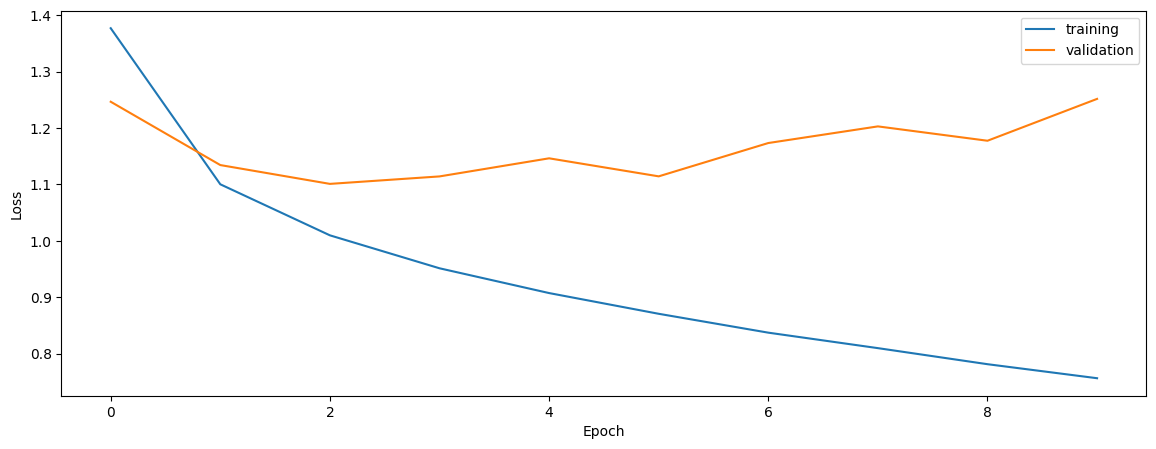

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6099430301333789
0.5637623660346249
0.6007978825547604


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5794813103955423
0.5561690107458913
0.5352014400129439


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5756995908213438
0.5643195666892349
0.5348914451468618


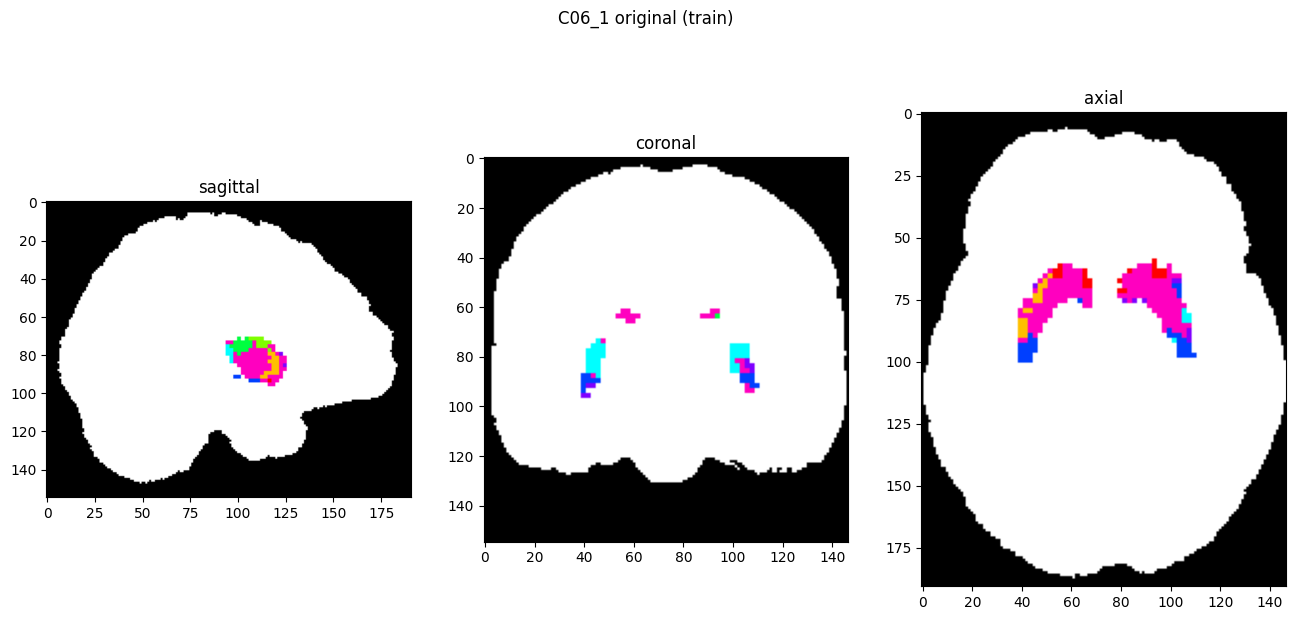

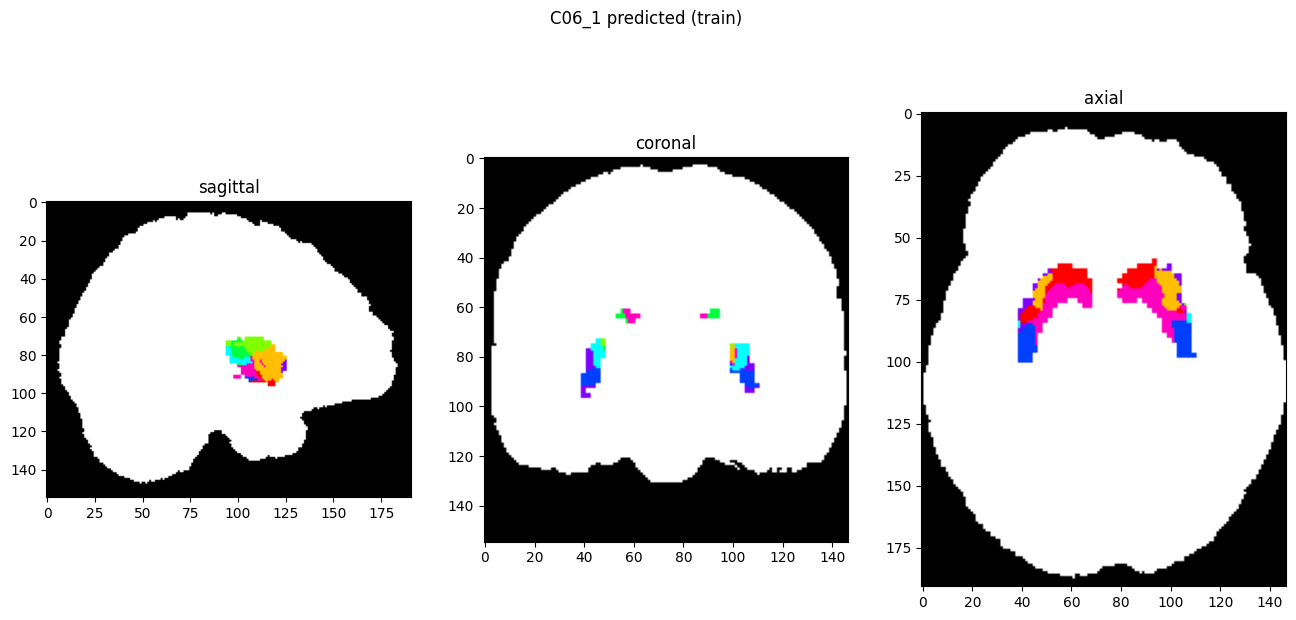

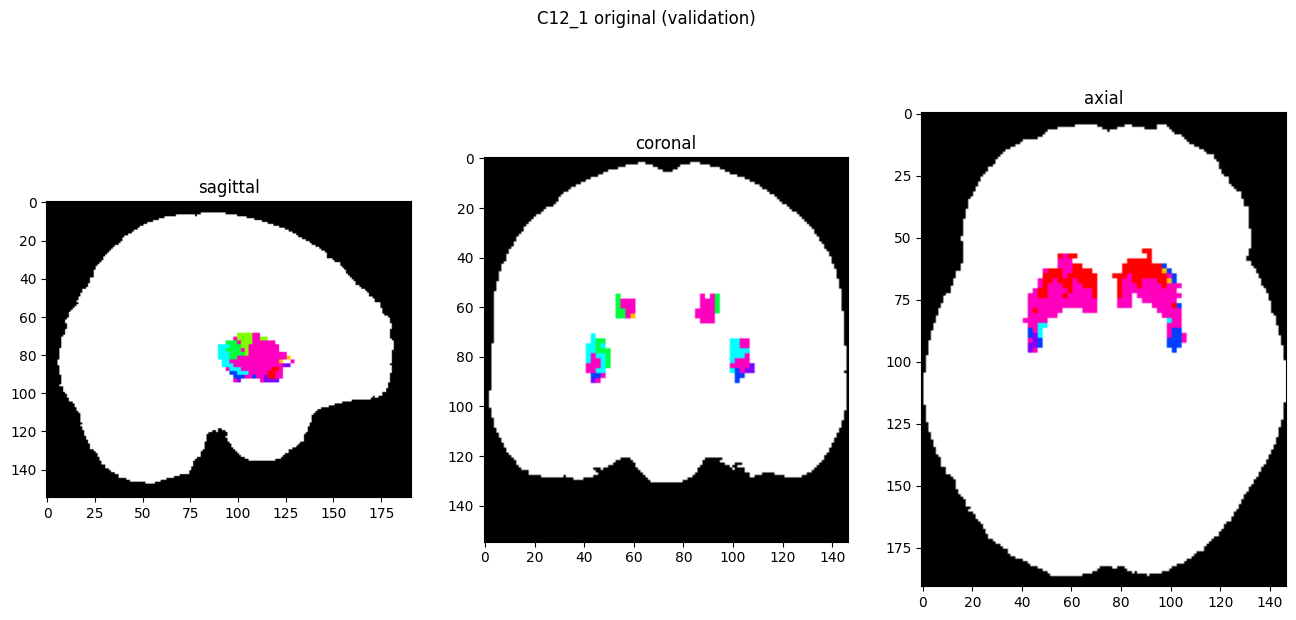

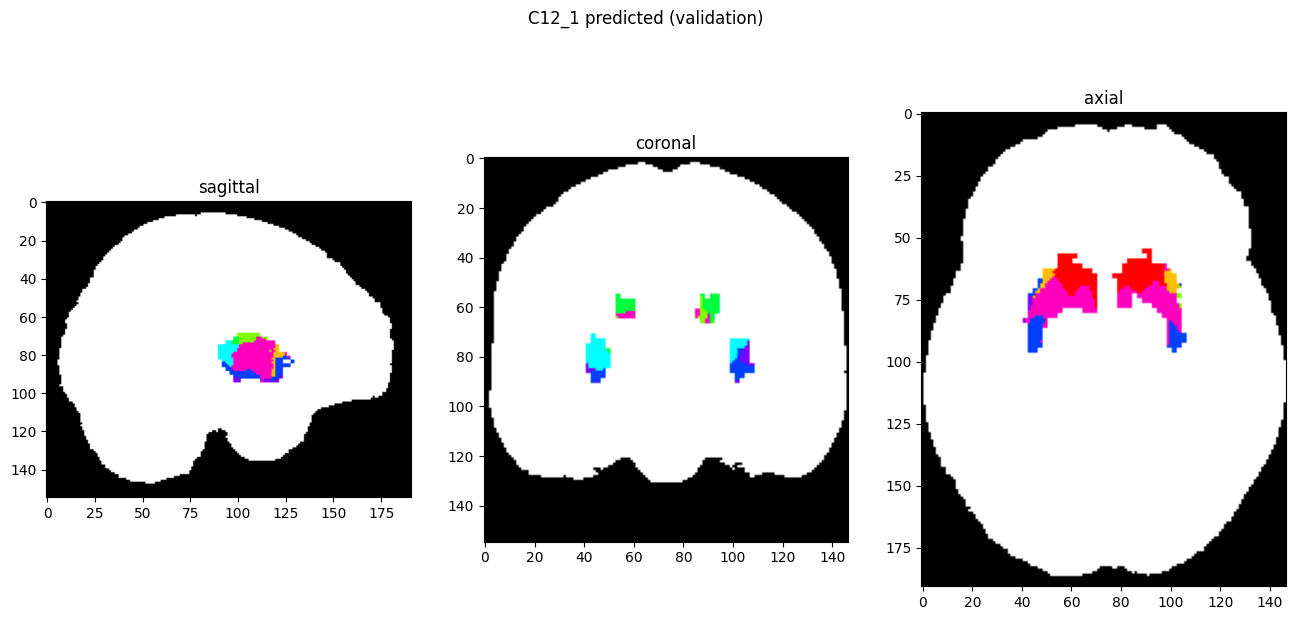

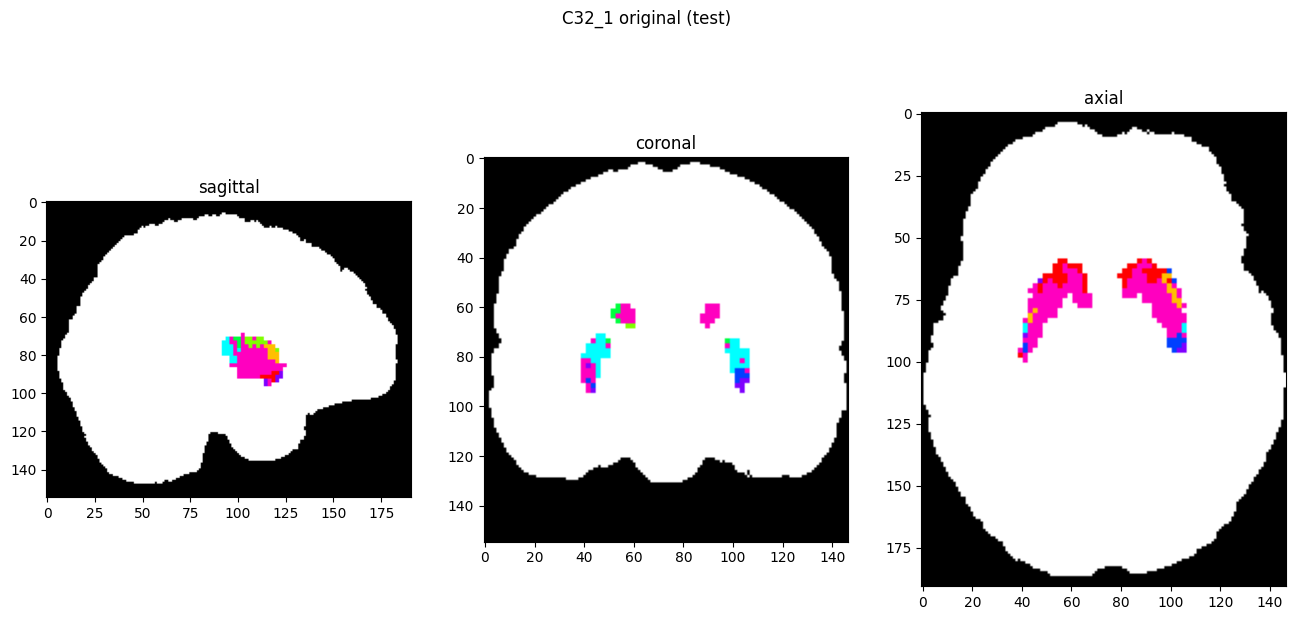

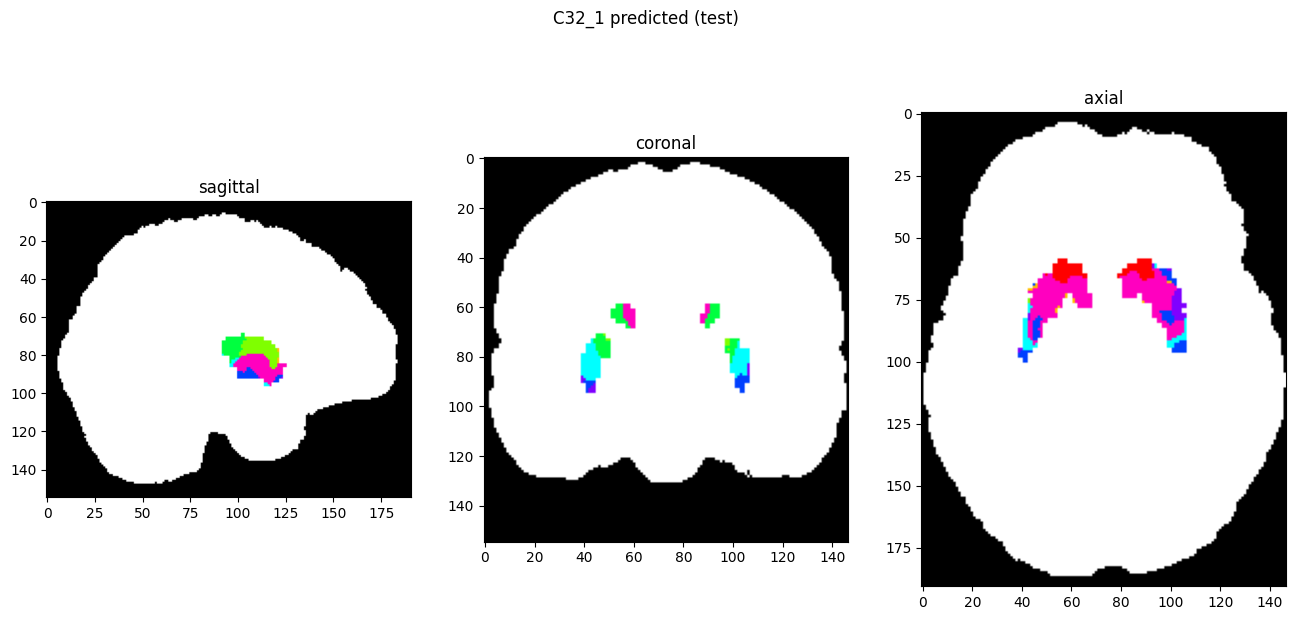

In [10]:
showResults(model, gen, threshold=0)